In [1]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchtext.data as data
from datetime import datetime
import spacy
from spacy.symbols import ORTH, LEMMA, POS, TAG
import re
import matplotlib.pyplot as plt
from bleu import moses_multi_bleu
%matplotlib inline

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
torch.manual_seed(42)

In [4]:
NLP = spacy.load('en')

def tokenizer(s):
    s = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(s))
    s = re.sub(r"[ ]+", " ", s)
    s = re.sub(r"\!+", "!", s)
    s = re.sub(r"\,+", ",", s)
    s = re.sub(r"\?+", "?", s)
    if (s.startswith("'") and s.endswith("'")) or (s.startswith('"') and s.endswith('"')):
        s = s[1:-1]
    MAX_CHARS = 20_000
    if (len(s) > MAX_CHARS):
        s = s[:MAX_CHARS]
        
    special_case = [{ORTH: '<nl>'}]
    NLP.tokenizer.add_special_case('<nl>', special_case)
    return [x.text for x in NLP.tokenizer(s) if x.text != " "]

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [5]:
TEXT = torchtext.data.Field(eos_token='<eos>', 
                            init_token='<sos>', 
                            tokenize=tokenizer, 
                            lower=True)
LABEL = torchtext.data.Field(sequential=False, unk_token=None)

In [6]:
class Multi30KEminem(torchtext.data.Dataset):

    urls = ['http://files.deeppavlov.ai/datasets/multi30k_eminem.zip']
    name = 'multi30k_eminem'
    dirname = ''

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
       
        fields = [('text', text_field), ('label', label_field)]
        examples = []

        with open(path) as f:
            for line in f.readlines():
                line = line.strip()
                label = line[-1]
                text = line[:-2]
                examples.append(data.Example.fromlist([text, label], fields))
        
        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='multi30k_eminem.train.txt', 
               validation='multi30k_eminem.valid.txt', 
               test='multi30k_eminem.test.txt', **kwargs):
        
        return super().splits(
            root=root, text_field=text_field, label_field=label_field,
            train=train, validation=validation, test=test, **kwargs)

    @classmethod
    def iters(cls, batch_size=32, device=0, root='.data', vectors=None, **kwargs):
        
        TEXT = data.Field()
        LABEL = data.Field(sequential=False)

        train, valid, test = cls.splits(TEXT, LABEL, root=root, **kwargs)

        TEXT.build_vocab(train, vectors=vectors)
        LABEL.build_vocab(train)

        return data.BucketIterator.splits(
            (train, test), batch_size=batch_size, device=device)


In [7]:
Multi30KEminem.download('.')

'./multi30k_eminem/'

In [8]:
train_ds, valid_ds, _ = Multi30KEminem.splits(TEXT, LABEL, '.')
len(train_ds), len(valid_ds)

(58000, 2000)

In [9]:
TEXT.build_vocab(train_ds)
LABEL.build_vocab(train_ds)
len(TEXT.vocab) , len(LABEL.vocab)

(17670, 2)

In [10]:
LABEL.vocab.itos[0], LABEL.vocab.itos[1]

('0', '1')

In [11]:
batch_size = 50

In [12]:
train_dl = torchtext.data.Iterator(train_ds, batch_size, repeat=False, shuffle=False)
valid_dl = torchtext.data.Iterator(valid_ds, batch_size, repeat=False)
gen_dl = torchtext.data.Iterator(train_ds, 1, repeat=False)

In [13]:
vocab_size = len(TEXT.vocab)

In [14]:
TEXT.vocab.load_vectors('fasttext.en.300d')

In [15]:
def to_onehot(data, n_digits):
    y = torch.zeros(data.shape[0], n_digits).cuda().scatter(1,data[:,None],1)
    return y

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers, lr = 1e-4, dropout=0.0, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
            
        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout, bidirectional = True)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
        
    def forward(self, x, hidden = None):
        x = self.emb(x)
        o, (h, c) = self.rnn(x, hidden)
        
        (_, batch_size, hidden_size) = c.shape # [2*n_layers, batch_size, hidden_size]
        c = c.view(-1, 2, batch_size, hidden_size) # [n_layers, 2, batch_size, hidden_size] 
        c = c[-1] # take only last layer
        c = torch.cat((c[0], c[1]), 1) # concatenate ontput from both directions to single vector
        
        return c
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [17]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, prior_size, n_layers, dropout=0.0, lr = 1e-4, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
        
        self.rnn = nn.LSTM(emb_size + prior_size, hidden_size, n_layers, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
    def forward(self, x, z, hidden = None, y = None):
        x = self.emb(x)
        
        (seq_len, batch_size, emb_size) = x.shape
        z = z[None, :, :]
        z = z.repeat(seq_len, 1, 1)
        x = torch.cat((x, z), 2)
        
        if y is not None:
            y = y[None, :, :]
            y = y.repeat(seq_len, 1, 1)
            x = torch.cat([x, y], dim=2)
        
        o, (h, c) = self.rnn(x, hidden)
        
        (seq_len, batch_size, hidden_size) = o.shape
        
        x = o.view(-1, hidden_size)
        x = F.log_softmax(self.fc(x), dim=1)
        return x, (h, c)
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [18]:
class Discriminator(nn.Module):
    def __init__(self, sizes, dropout=False, lr=1e-4, bn=False, activation_fn=nn.Tanh(), last_fn=None, first_fn=None):
        super().__init__()
        
        layers = []
        
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
        self.optim = torch.optim.Adam(self.parameters(), lr)
        
    def forward(self, x, y=None):
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [19]:
class SeqDiscriminator(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, prior_size, n_layers, dropout=0.0, lr = 1e-4, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
        
        self.rnn = nn.GRU(emb_size + prior_size, hidden_size, n_layers, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.head = nn.Linear(hidden_size, 1)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
    def forward(self, x, y, hidden = None):
        x = self.emb(x)
        
        (seq_len, batch_size, emb_size) = x.shape
        
        if y is not None:
            y = y[None, :, :]
            y = y.repeat(seq_len, 1, 1)
            x = torch.cat([x, y], dim=2)
        
        o, h = self.rnn(x, hidden)

        (seq_len, batch_size, hidden_size) = o.shape
        
        x = o[-1].view(-1, hidden_size)
        x = F.relu(self.fc(x))
        x = self.bn(x)
        x = self.head(x)
        return x
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [20]:
def seq_to_str(seq):
    (seq_len, batch_size) = seq.shape
    result = []
    for i in range(batch_size):
        result.append(" ".join([TEXT.vocab.itos[w_idx.item()] for w_idx in seq[:,i].view(-1)]))
    return result

In [21]:
def train_raae(epoch, enc, dec, disc, seq_disc, prior_size, train_dl):
    enc.train()
    dec.train()
    disc.train()
    seq_disc.train()
    
    train_g_loss = 0.0
    train_ae_loss = 0.0
    train_disc_loss = 0.0
    train_seq_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(train_dl):
       
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        # ======== train ZDisc ========
        
        enc.zero_grad()
        disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()

        latent = enc(seq)
        fake_pred = disc(latent, label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        disc_loss.backward()
        disc.optim.step()
        
        
        # ======== train SeqDisc ========
        
        enc.zero_grad()
        dec.zero_grad()
        seq_disc.zero_grad()
                
        latent = enc(seq)
        
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        fake_pred = seq_disc(dec_seq, label)
        true_pred = seq_disc(seq, label)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        seq_disc_loss = 0.5*(fake_loss + true_loss)
        
        seq_disc_loss.backward()
        seq_disc.optim.step()
        
        # ======== train AE ========
        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()
        seq_disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred_z = disc(latent, label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred_z, batch_ones)
        
        fake_pred_seq = seq_disc(dec_seq, label)
        
        dec_loss = F.binary_cross_entropy_with_logits(fake_pred_seq, batch_ones)
        
        g_loss = ae_loss + enc_loss + dec_loss
        
        g_loss.backward()
        dec.optim.step()
        enc.optim.step()
        
        # ----------------------------------------------------
        
        train_g_loss += g_loss.item()
        train_ae_loss += ae_loss.item()
        train_disc_loss += disc_loss.item()
        train_seq_disc_loss += seq_disc_loss.item()
        
        
        #_, w_idxs = output.topk(1, dim=1)
        #dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))

    train_g_loss /= len(train_dl)
    train_ae_loss /= len(train_dl)
    train_disc_loss /= len(train_dl)
    train_seq_disc_loss /= len(train_dl)
    
    train_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE: {:.5f}, G: {:.5f}, ZD: {:.5f}, SeqD: {:.5f}  at {}".format(
        epoch, 'Train', train_bleu, train_ae_loss, train_g_loss, train_disc_loss, 
        train_seq_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return train_ae_loss, train_g_loss, train_disc_loss, train_seq_disc_loss, train_bleu

In [22]:
def validate_raae(epoch, enc, dec, disc, seq_disc, prior_size, valid_dl, name):
    enc.eval()
    dec.eval()
    disc.eval()
    seq_disc.eval()
    
    valid_g_loss = 0.0
    valid_ae_loss = 0.0
    valid_disc_loss = 0.0
    valid_seq_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(valid_dl):
            
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        # ======== valid Disc ========
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()
        
        fake_pred = disc(enc(seq), label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        # ======== valid SeqDisc ========

        latent = enc(seq)

        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        fake_pred = seq_disc(dec_seq, label)
        true_pred = seq_disc(seq, label)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        seq_disc_loss = 0.5*(fake_loss + true_loss)
        
        
        # ======== valid AE ========
        
        z = torch.randn((batch_size, prior_size))
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred_z = disc(latent,label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred_z, batch_ones)
        
        fake_pred_seq = seq_disc(dec_seq, label)
        
        dec_loss = F.binary_cross_entropy_with_logits(fake_pred_seq, batch_ones)
        
        g_loss = ae_loss + enc_loss + dec_loss
        
        # ------------------------------------------------------------------
        
        valid_g_loss += g_loss.item()
        valid_ae_loss += ae_loss.item()
        valid_disc_loss += disc_loss.item()
        valid_seq_disc_loss += seq_disc_loss.item()
        
        #_, w_idxs = output.topk(1, dim=1)
        #dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))
        
    valid_g_loss /= len(valid_dl)
    valid_ae_loss /= len(valid_dl)
    valid_disc_loss /= len(valid_dl)
    valid_seq_disc_loss /= len(valid_dl)
    
    valid_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE: {:.5f}, G: {:.5f}, ZD: {:.5f}, SeqD: {:.5f}  at {}".format(
        epoch, name, valid_bleu, valid_ae_loss, valid_g_loss, valid_disc_loss, valid_seq_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return valid_ae_loss, valid_g_loss, valid_disc_loss, valid_seq_disc_loss, valid_bleu

In [23]:
def decode_z(dec, z, seq_len, label):
    dec.eval()
    
    (batch_size, hidden_size) = z.shape
    
    label = to_onehot(label, 2)
    
    x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
    h = None
        
    dec_seq = None
    
    for i in range(seq_len):
        o, h = dec(x, z, h, label)
        _, w_idxs = o.topk(1)
        x = w_idxs.view(1, -1)
        dec_seq = w_idxs if dec_seq is None else torch.cat((dec_seq, w_idxs), 0)
        if batch_size == 1 and TEXT.vocab.itos[w_idxs.item()] == '<eos>':
            break
        
    return dec_seq

In [24]:
def print_decoded(enc, dec, dl):
    enc.eval()
    dec.eval()
    
    b = next(iter(dl))
    seq = b.text
    seq = seq[1:]
    
    label = b.label
    
    (seq_len, batch_size) = seq.shape
    
    z = enc(seq)
    
    dec_seq = decode_z(dec, z, seq_len, label)

    print("\nOrigin:  {}".format(seq_to_str(seq.detach())))
    print("Decoded: {}\n".format(seq_to_str(dec_seq.detach())))
    

In [25]:
def print_sample(dec, sample_size, max_seq_len):
    dec.eval()
    
    z = torch.randn(1, sample_size).cuda()
    print("\nRandom sample:")
    
    label_0 = torch.zeros(1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_0)
    print("\tdecoded w. style M: {}".format(seq_to_str(dec_seq.detach())))
    
    label_1 = (torch.zeros(1) + 1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_1)
    print("\tdecoded w. style E: {}\n".format(seq_to_str(dec_seq.detach())))

In [26]:
def plot_metrics(metrics, idx = 0, metric_name = 'Loss'):
    plt.figure(figsize=(20,10))
    for model, (trn, val, tst) in metrics.items():
        trn = [metric[idx] for metric in trn]
        val = [metric[idx] for metric in val]
        tst = [metric[idx] for metric in tst]
        if trn:
            plt.plot(trn, label=f'{model} Train')
        if val:
            plt.plot(val, label=f'{model} Valid', marker='v')
        if tst:
            plt.plot(tst, label=f'{model} Test', marker='o')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.show()

In [27]:
hidden_size = 500
prior_size = 2 * hidden_size
label_size = 2

In [28]:
Enc = Encoder(vocab_size, 300, hidden_size, n_layers=3, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()
Dec = Decoder(vocab_size, 300, hidden_size, prior_size + label_size, n_layers=3, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()
ZDisc = Discriminator([prior_size + label_size, hidden_size, 1], dropout=0.3, lr=1e-4, activation_fn=nn.LeakyReLU(0.2)).cuda()
SeqDisc = SeqDiscriminator(vocab_size, 300, hidden_size, prior_size = label_size, n_layers=3, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()

In [29]:
Enc

Encoder(
  (emb): Embedding(17670, 300)
  (rnn): LSTM(300, 500, num_layers=3, dropout=0.3, bidirectional=True)
)

In [30]:
Dec

Decoder(
  (emb): Embedding(17670, 300)
  (rnn): LSTM(1302, 500, num_layers=3, dropout=0.3)
  (fc): Linear(in_features=500, out_features=17670, bias=True)
)

In [31]:
ZDisc

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1002, out_features=500, bias=True)
    (1): Dropout(p=0.3)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [32]:
SeqDisc

SeqDiscriminator(
  (emb): Embedding(17670, 300)
  (rnn): GRU(302, 500, num_layers=3, dropout=0.3)
  (fc): Linear(in_features=500, out_features=500, bias=True)
  (bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=500, out_features=1, bias=True)
)

In [33]:
metrics = {'CRAAE': ([], [], [])}

========== Start epoch 1 at 21:05:07 ==========
Epoch   1 Train: BLEU: 48.64, AE: 3.52478, G: 4.74437, ZD: 1.28794, SeqD: 0.69325  at 21:11:00
Epoch   1 Valid: BLEU: 52.38, AE: 2.97267, G: 4.32952, ZD: 0.77389, SeqD: 0.69317  at 21:11:06

Origin:  ['a white dog plays with a brown dog on carpet . <eos>']
Decoded: ['a a a a a a a a a a a .']


Random sample:
	decoded w. style M: ['a a a a a a a a . <eos>']
	decoded w. style E: ['a a a a a a a a . <eos>']

========== Start epoch 2 at 21:11:06 ==========
Epoch   2 Train: BLEU: 51.82, AE: 2.98225, G: 4.31837, ZD: 0.74021, SeqD: 0.69315  at 21:16:56
Epoch   2 Valid: BLEU: 52.63, AE: 2.94572, G: 4.26740, ZD: 0.73284, SeqD: 0.69316  at 21:17:02

Origin:  ['a lady is inflating an incredible hulk toy . <eos>']
Decoded: ['a man in a a a a a a a']


Random sample:
	decoded w. style M: ['a man in a a a a a a a . . <eos>']
	decoded w. style E: ['a man in a a a a a a a . <eos>']

========== Start epoch 3 at 21:17:02 ==========
Epoch   3 Train: BLEU: 

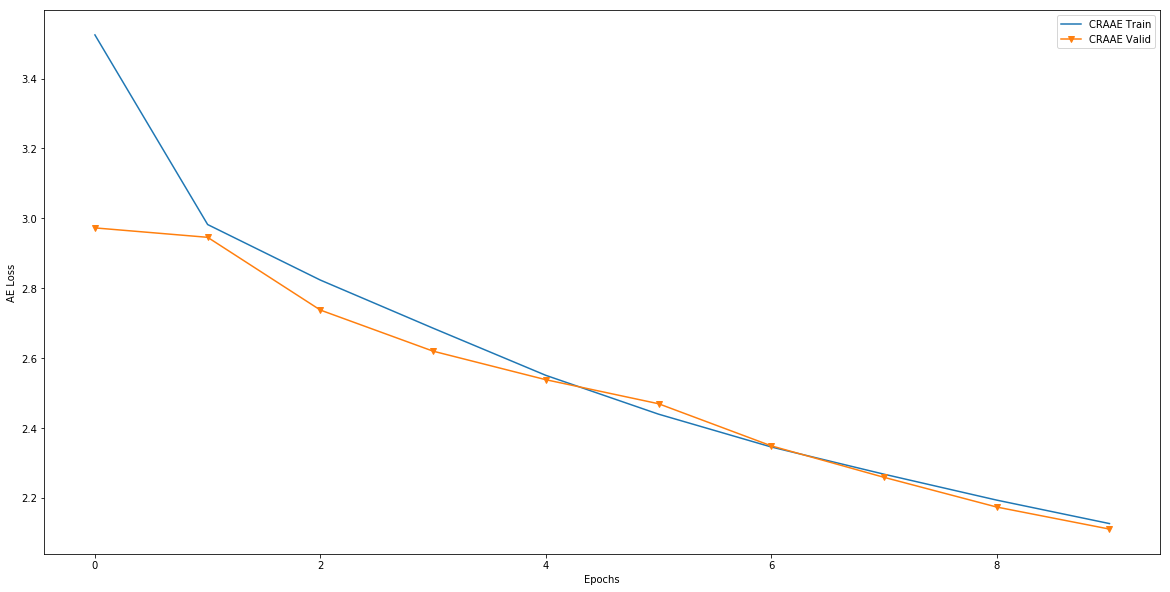

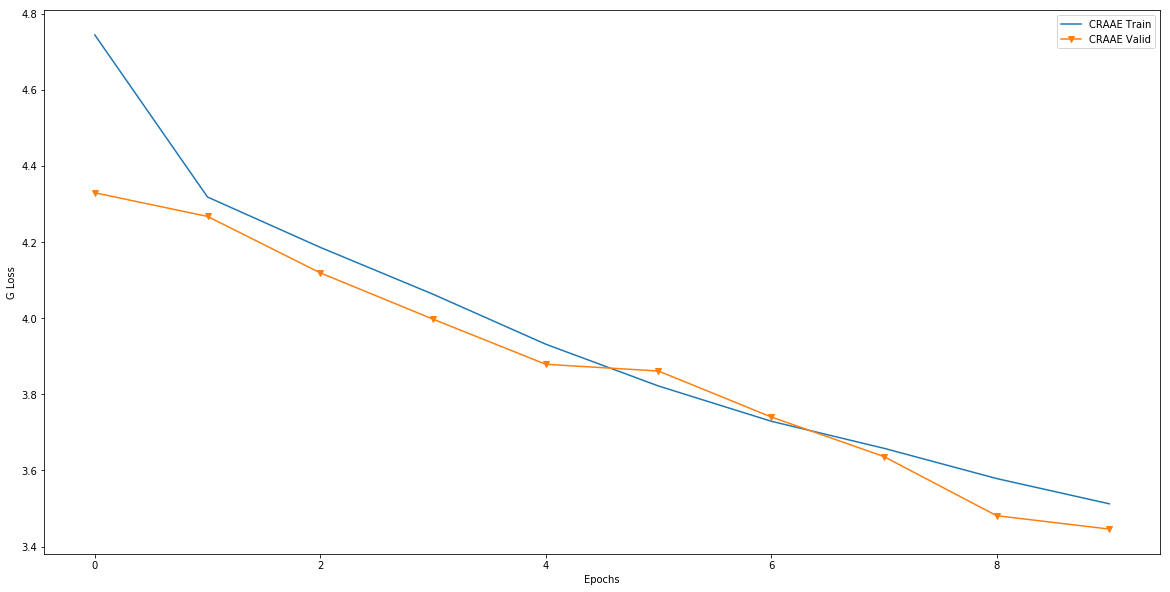

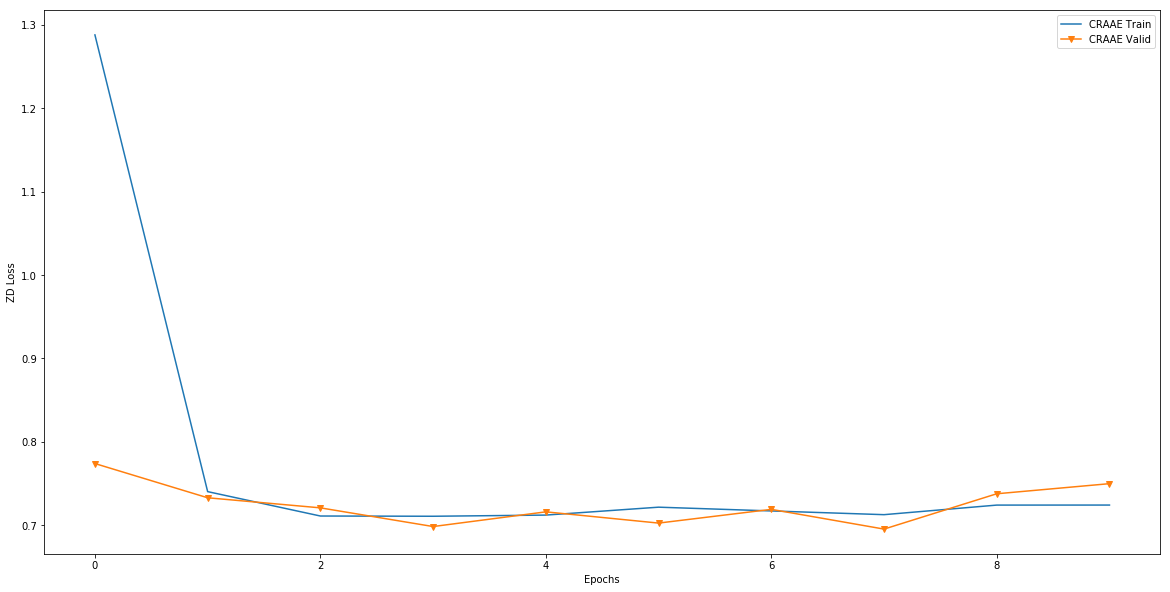

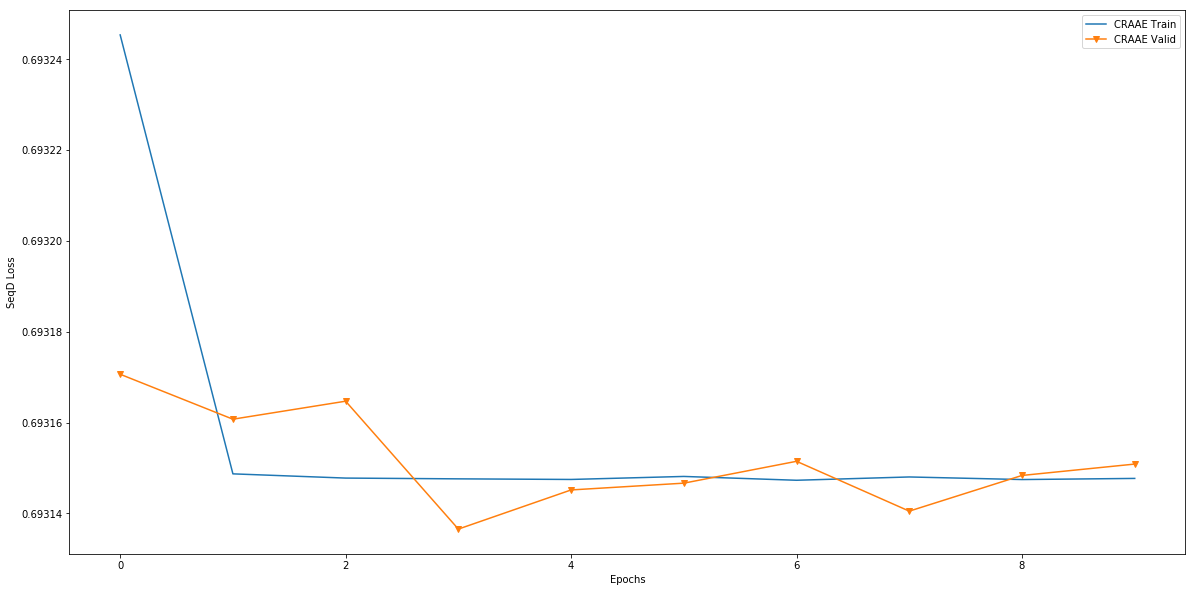

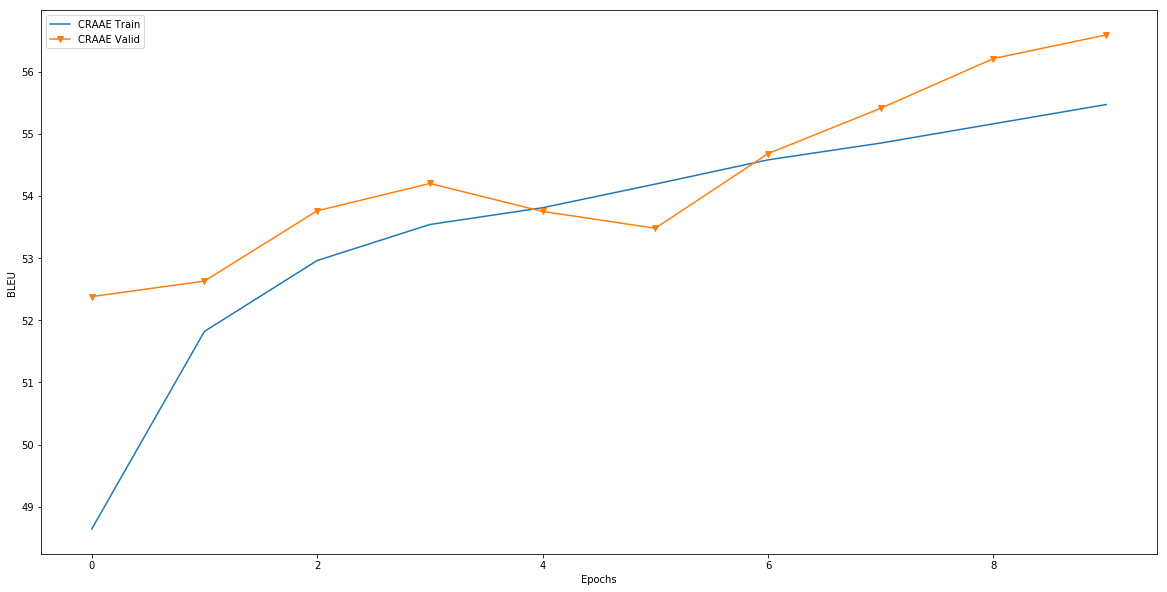

========== Start epoch 11 at 22:04:37 ==========
Epoch  11 Train: BLEU: 55.86, AE: 2.04999, G: 3.44085, ZD: 0.71755, SeqD: 0.69315  at 22:10:29
Epoch  11 Valid: BLEU: 56.97, AE: 2.04692, G: 3.44196, ZD: 0.69520, SeqD: 0.69315  at 22:10:35

Origin:  ["there 's a place called heaven and a place called hell <eos>"]
Decoded: ["it 's a fuckin , the fuck of a little bit of"]


Random sample:
	decoded w. style M: ['a group of men are playing on a large ball . <eos>']
	decoded w. style E: ['a group of people are playing at the large ball . <eos>']

========== Start epoch 12 at 22:10:35 ==========
Epoch  12 Train: BLEU: 56.23, AE: 1.97639, G: 3.36473, ZD: 0.72198, SeqD: 0.69315  at 22:16:25
Epoch  12 Valid: BLEU: 57.13, AE: 1.98255, G: 3.34899, ZD: 0.70374, SeqD: 0.69315  at 22:16:31

Origin:  ['it takes some massive balls to do some shit like that <eos>']
Decoded: ["it 's back , you 's , i 'm on my ass"]


Random sample:
	decoded w. style M: ['a group of men are playing looking at the beach . 

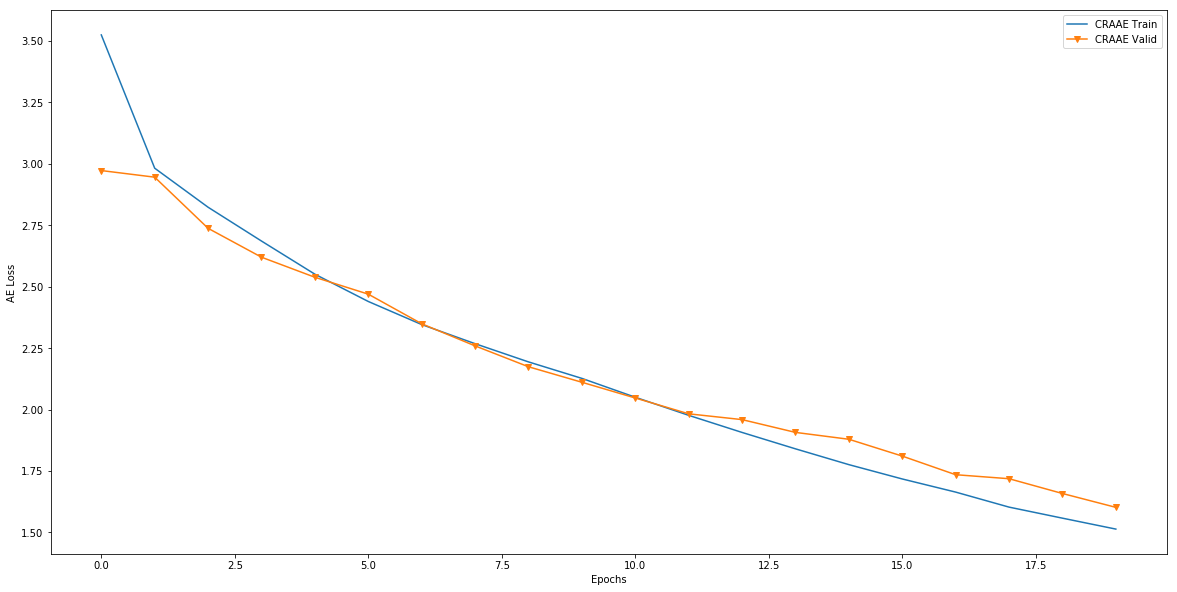

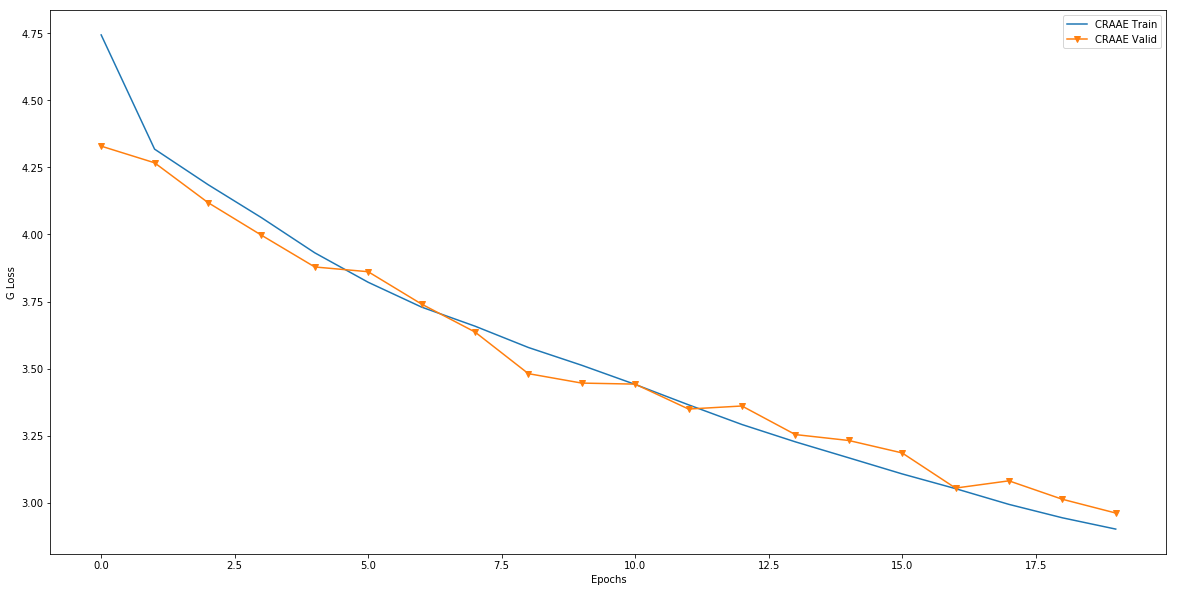

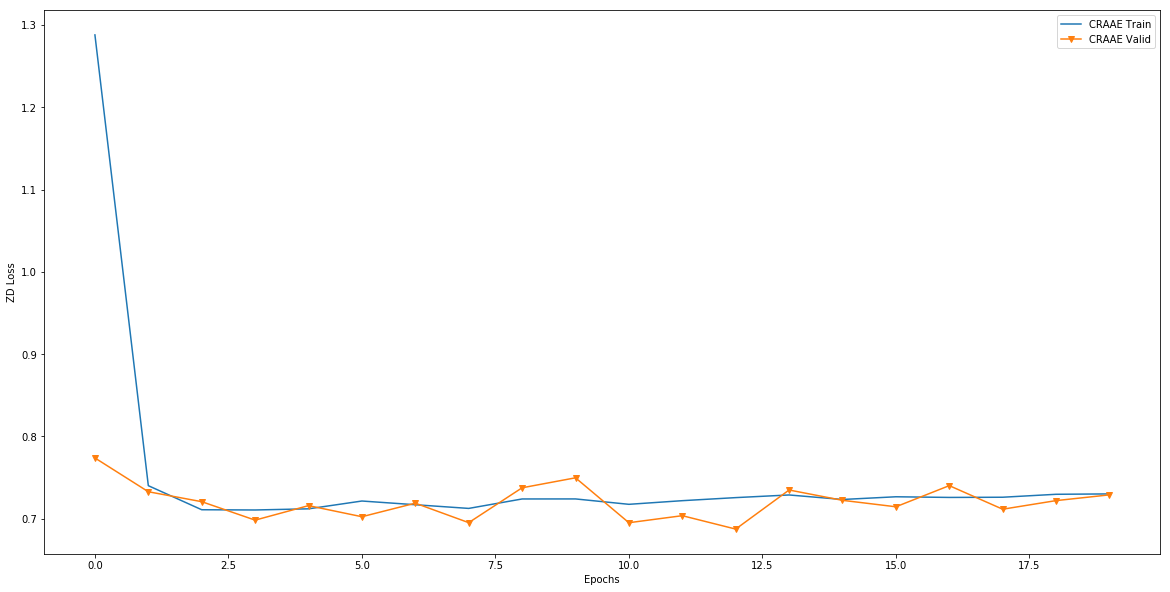

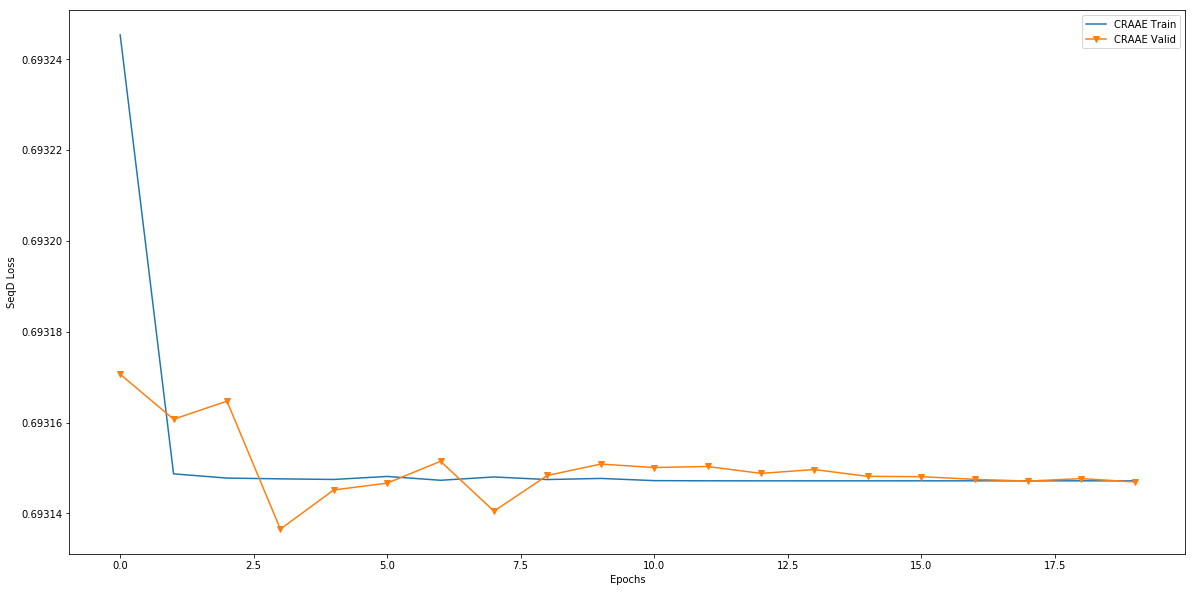

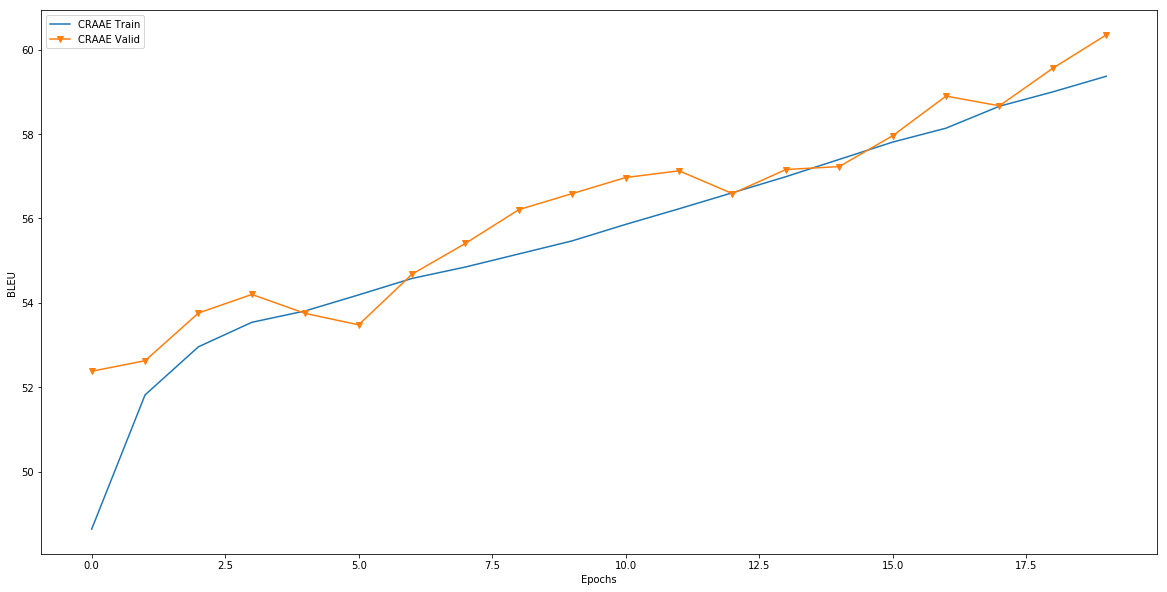

========== Start epoch 21 at 23:03:51 ==========
Epoch  21 Train: BLEU: 59.80, AE: 1.46867, G: 2.86120, ZD: 0.72816, SeqD: 0.69315  at 23:09:39
Epoch  21 Valid: BLEU: 60.62, AE: 1.56669, G: 2.93347, ZD: 0.71596, SeqD: 0.69315  at 23:09:45

Origin:  ['adults and children stand and play in front of steps near a wooded area . <eos>']
Decoded: ['group of children , and one in front with the middle of spectators . <eos>']


Random sample:
	decoded w. style M: ["do n't , but it can , this way is up <eos>"]
	decoded w. style E: ["do n't , but it go , it 're like <eos>"]

========== Start epoch 22 at 23:09:45 ==========
Epoch  22 Train: BLEU: 60.24, AE: 1.42329, G: 2.81152, ZD: 0.73146, SeqD: 0.69315  at 23:15:34
Epoch  22 Valid: BLEU: 61.77, AE: 1.49845, G: 2.91749, ZD: 0.69063, SeqD: 0.69315  at 23:15:40

Origin:  ['a person is jumping over a house on skis . <eos>']
Decoded: ['a person is jumping over a dirt in of water .']


Random sample:
	decoded w. style M: ['a woman with a beard and wea

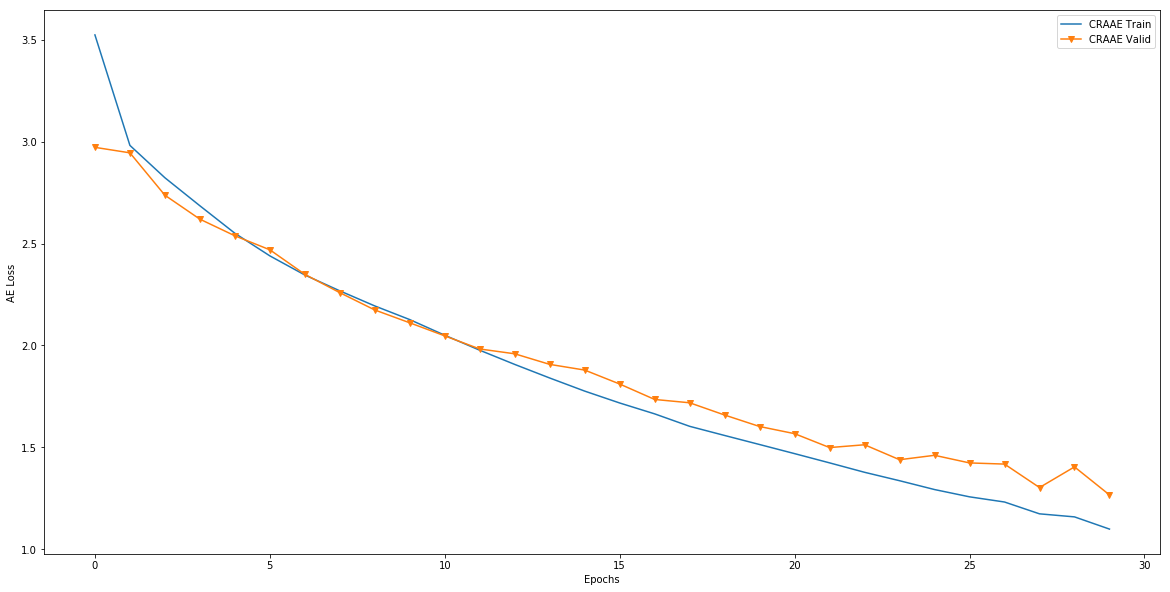

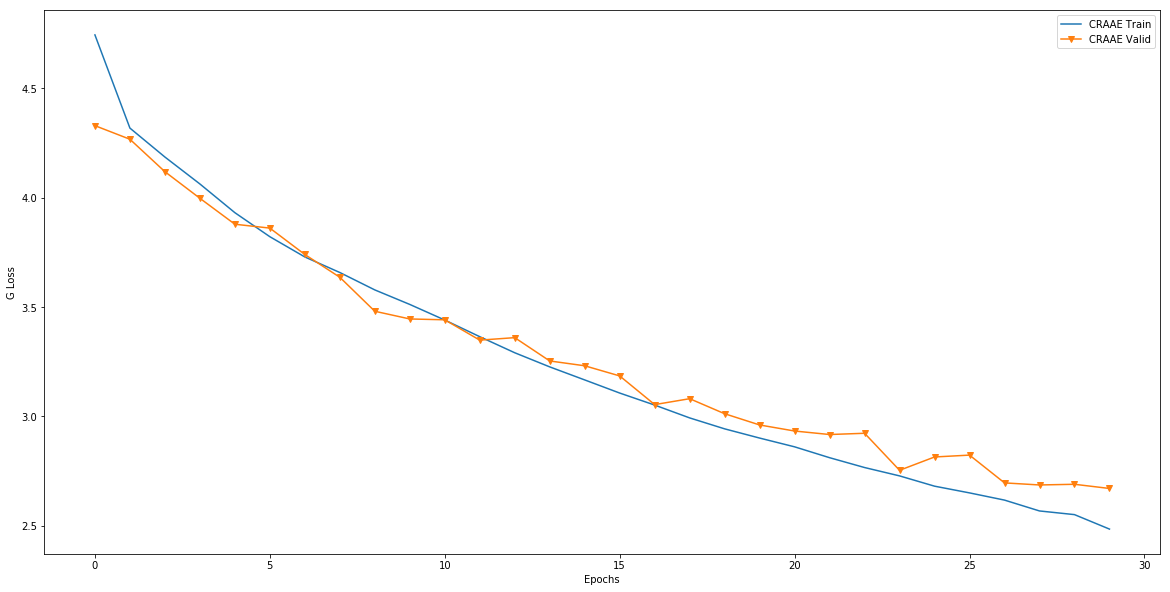

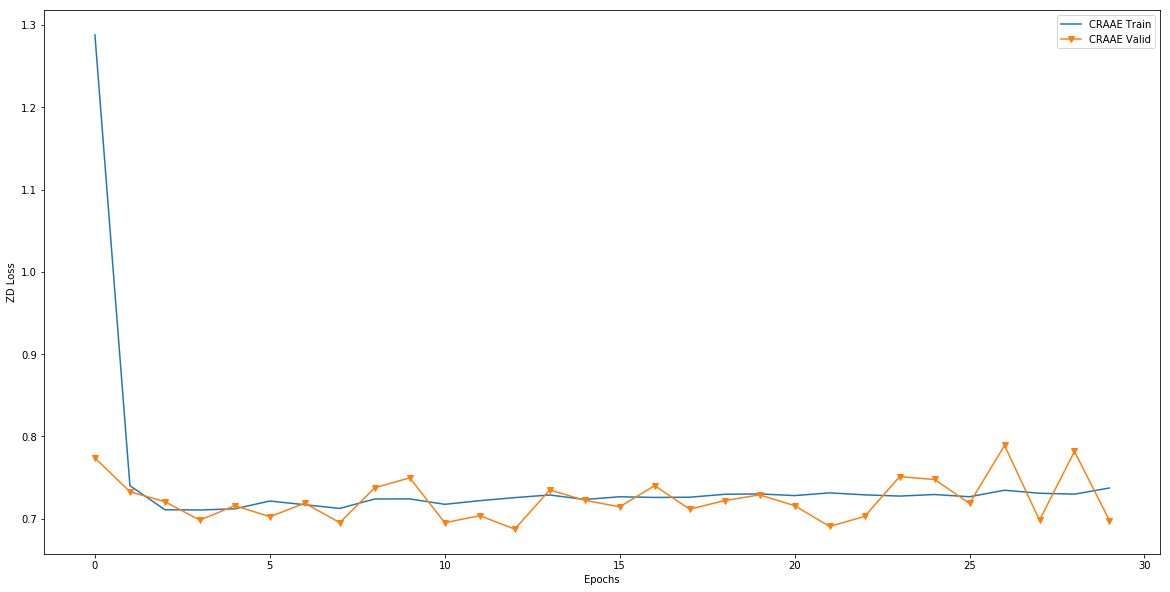

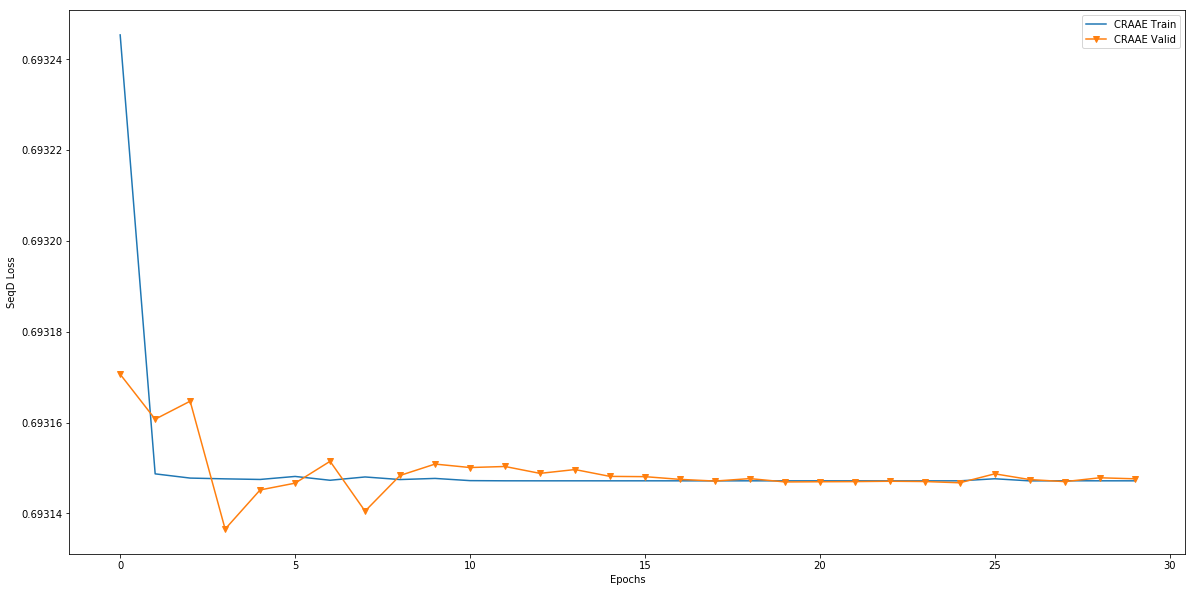

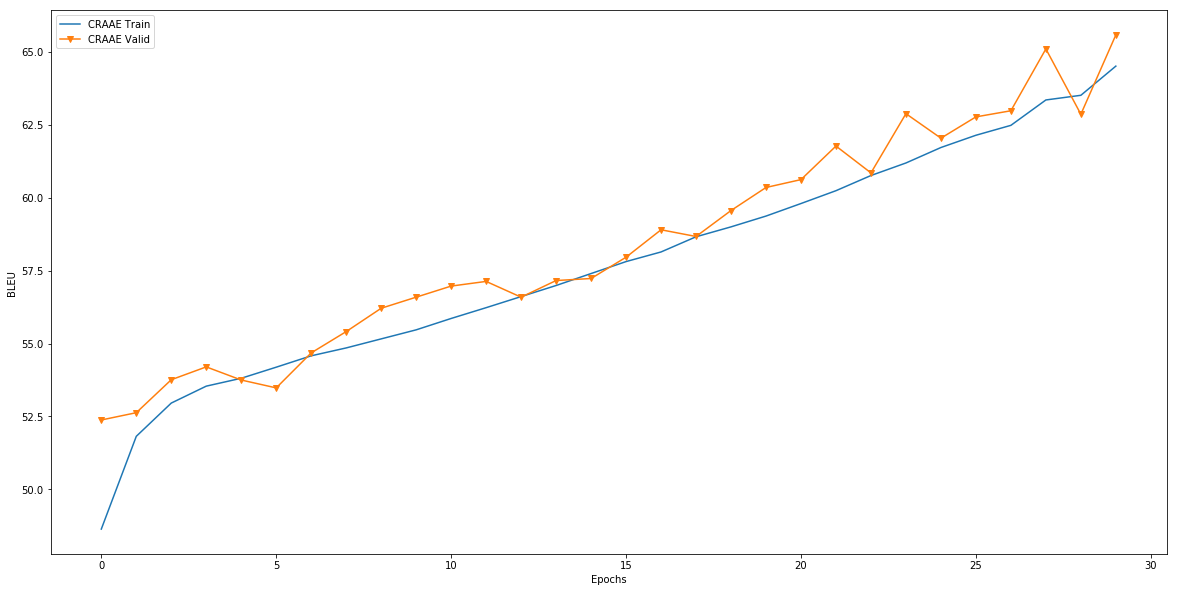

========== Start epoch 31 at 00:02:02 ==========
Epoch  31 Train: BLEU: 64.93, AE: 1.07091, G: 2.46107, ZD: 0.73396, SeqD: 0.69315  at 00:07:41
Epoch  31 Valid: BLEU: 65.50, AE: 1.25444, G: 2.66526, ZD: 0.70179, SeqD: 0.69315  at 00:07:47

Origin:  ["i said , i guess it 's time for you to hate me again <eos>"]
Decoded: ["i know , i think it 's here to me to do this , you"]


Random sample:
	decoded w. style M: ['person wearing pink shirt sits in water on a basketball . <eos>']
	decoded w. style E: ['girl my girl on stage , a black ball . <eos>']

========== Start epoch 32 at 00:07:47 ==========
Epoch  32 Train: BLEU: 65.35, AE: 1.04286, G: 2.43869, ZD: 0.72975, SeqD: 0.69315  at 00:13:25
Epoch  32 Valid: BLEU: 67.02, AE: 1.21733, G: 2.60674, ZD: 0.71548, SeqD: 0.69314  at 00:13:31

Origin:  ['three children jumping while an older man watches from a row of chairs nearby . <eos>']
Decoded: ['three children , two other male wearing work from a tree in their hands . <eos>']


Random sample

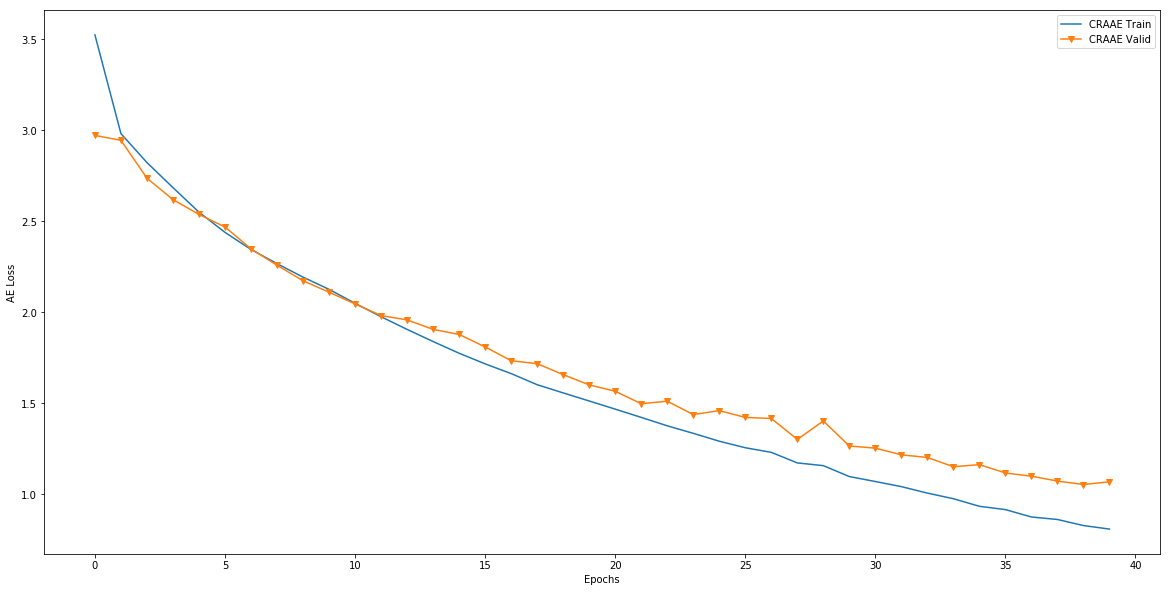

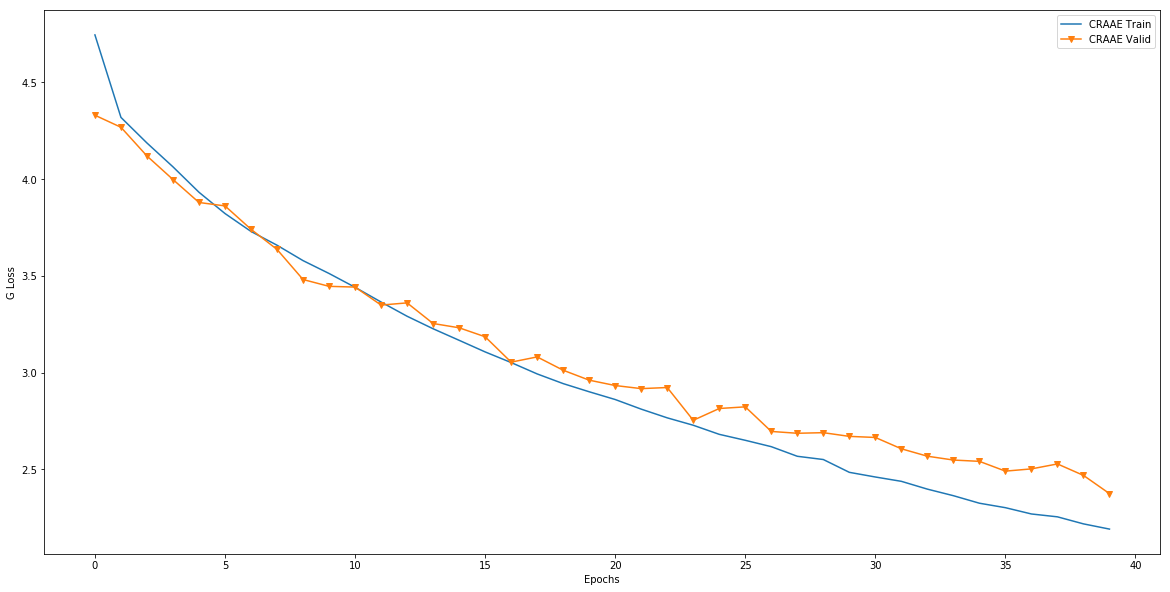

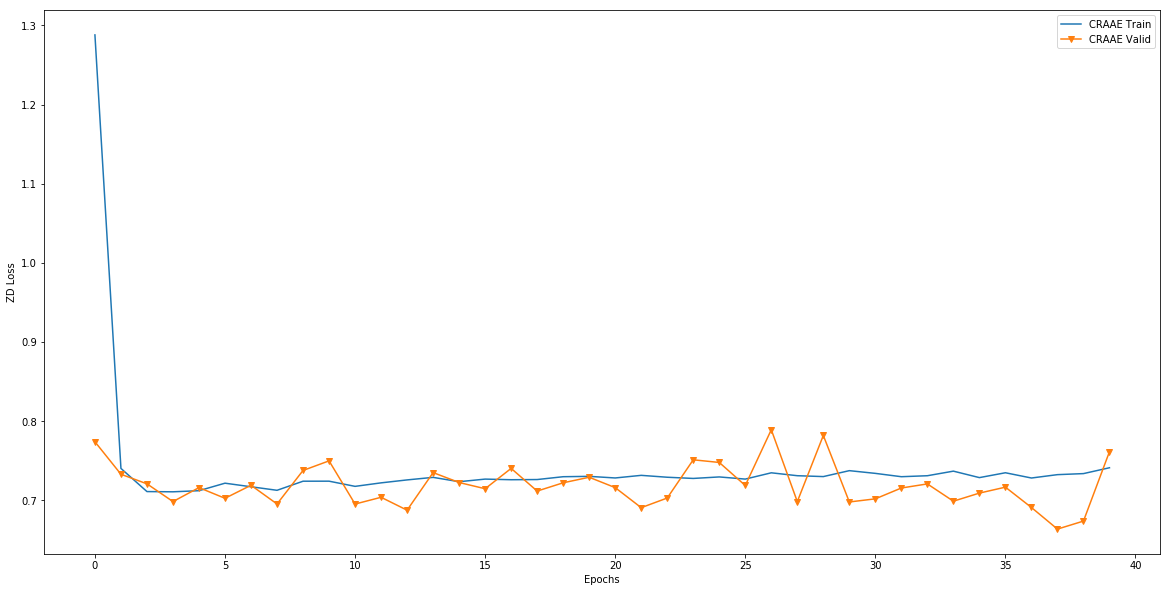

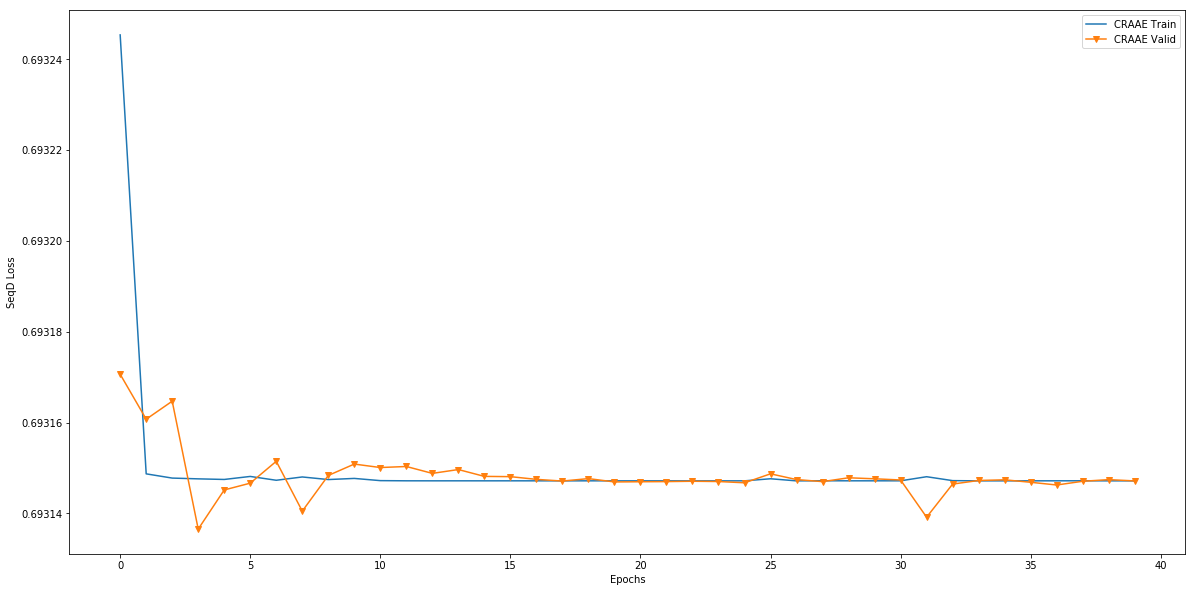

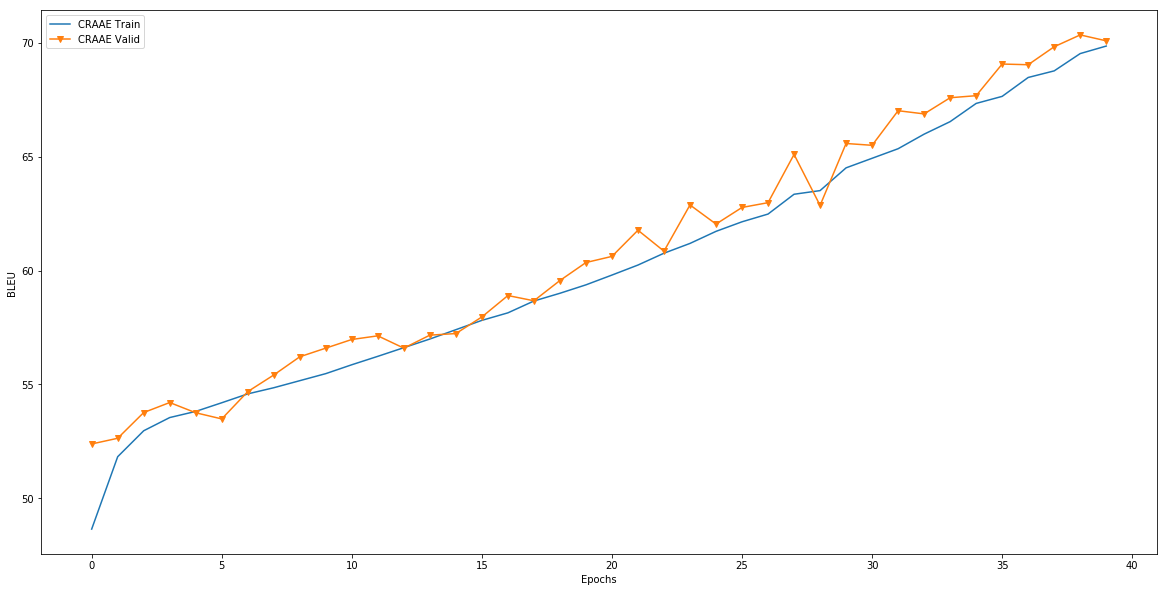

========== Start epoch 41 at 00:59:25 ==========
Epoch  41 Train: BLEU: 70.97, AE: 0.76760, G: 2.16057, ZD: 0.73408, SeqD: 0.69315  at 01:05:27
Epoch  41 Valid: BLEU: 69.99, AE: 1.05759, G: 2.41421, ZD: 0.71893, SeqD: 0.69315  at 01:05:35

Origin:  ['i got scribtures in my brain <eos>']
Decoded: ['i got scribtures in my name song']


Random sample:
	decoded w. style M: ['here got no back of the team of people in the track . <eos>']
	decoded w. style E: ['when you had him all the block of your mile house <eos>']

========== Start epoch 42 at 01:05:35 ==========
Epoch  42 Train: BLEU: 70.99, AE: 0.76105, G: 2.14873, ZD: 0.73521, SeqD: 0.69315  at 01:11:29
Epoch  42 Valid: BLEU: 70.53, AE: 1.03942, G: 2.45532, ZD: 0.69179, SeqD: 0.69315  at 01:11:35

Origin:  ['two men are using tools cutting into a green trailer . <eos>']
Decoded: ['two men are using martial arts for a tree in a classroom']


Random sample:
	decoded w. style M: ['older soccer with a bat of red team yellow ball on two han

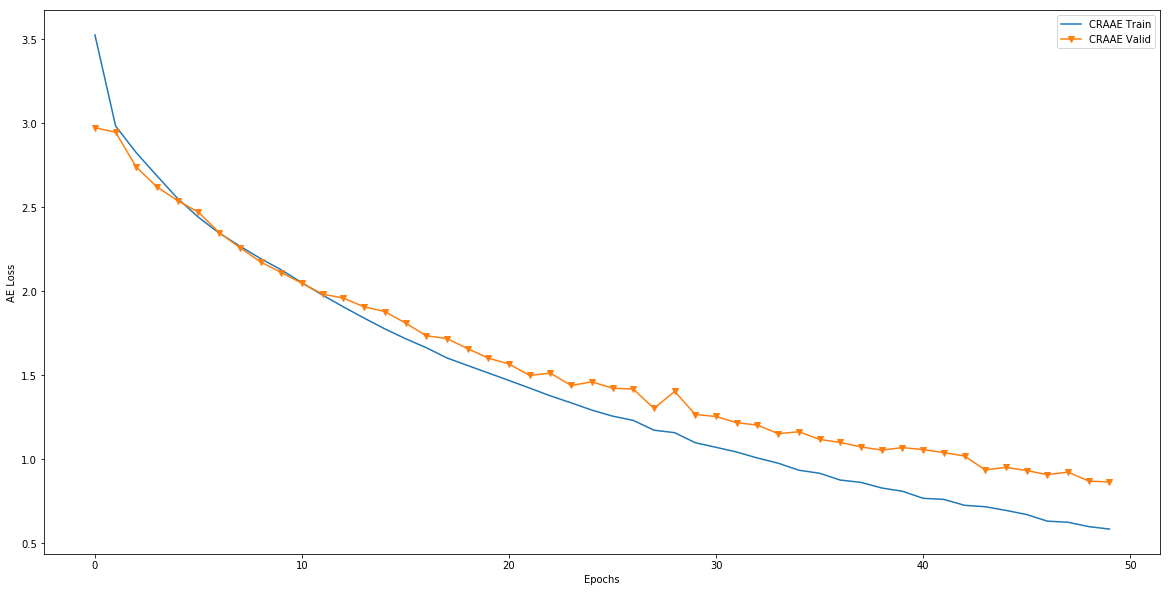

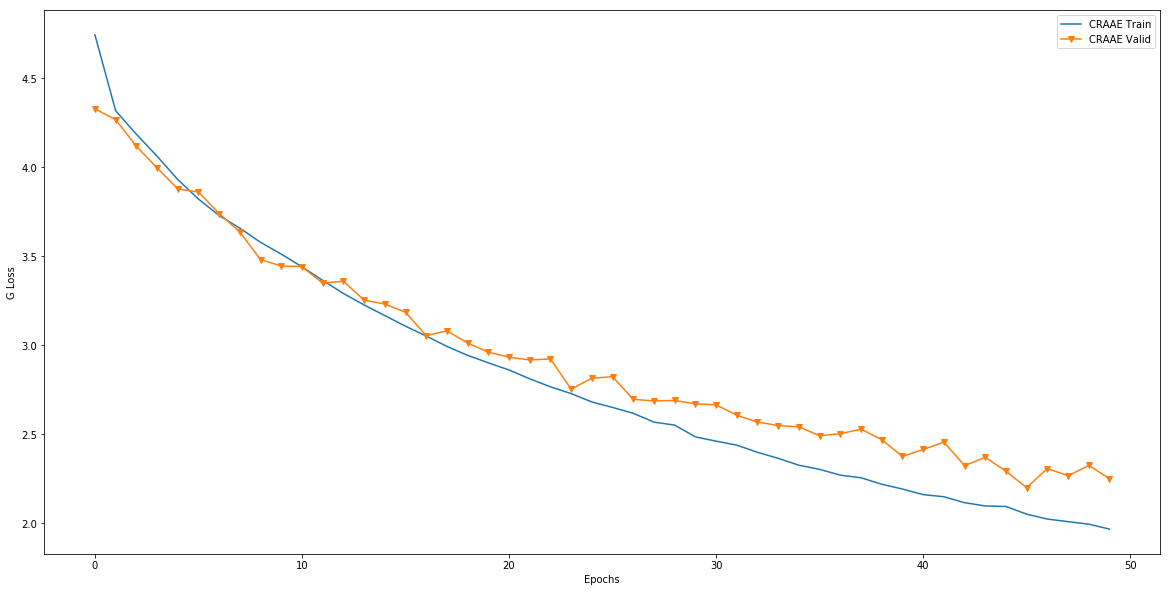

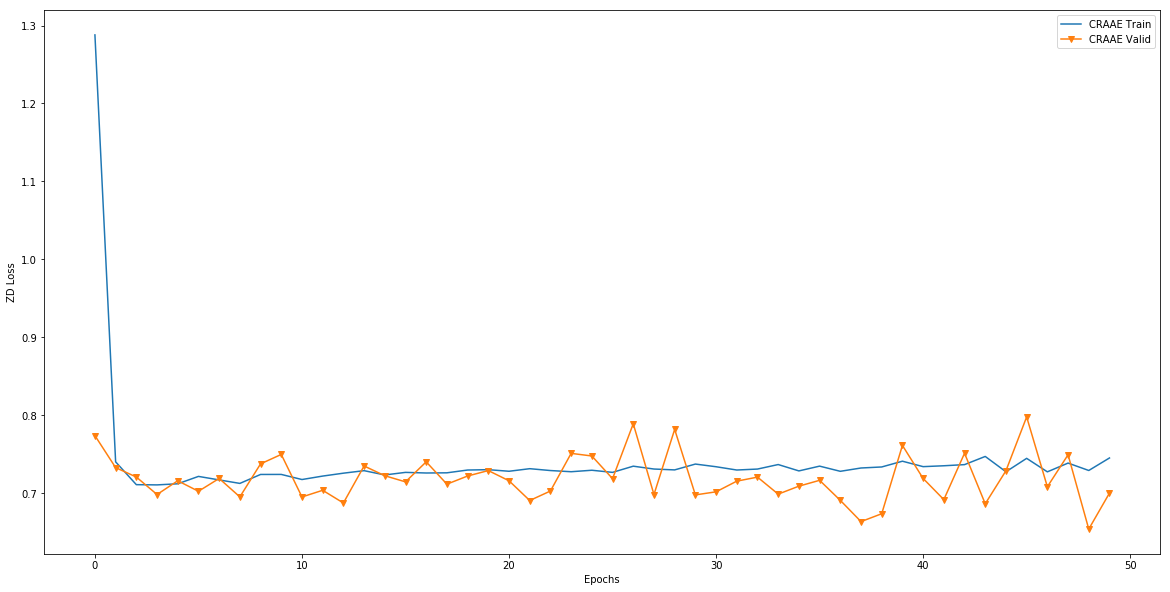

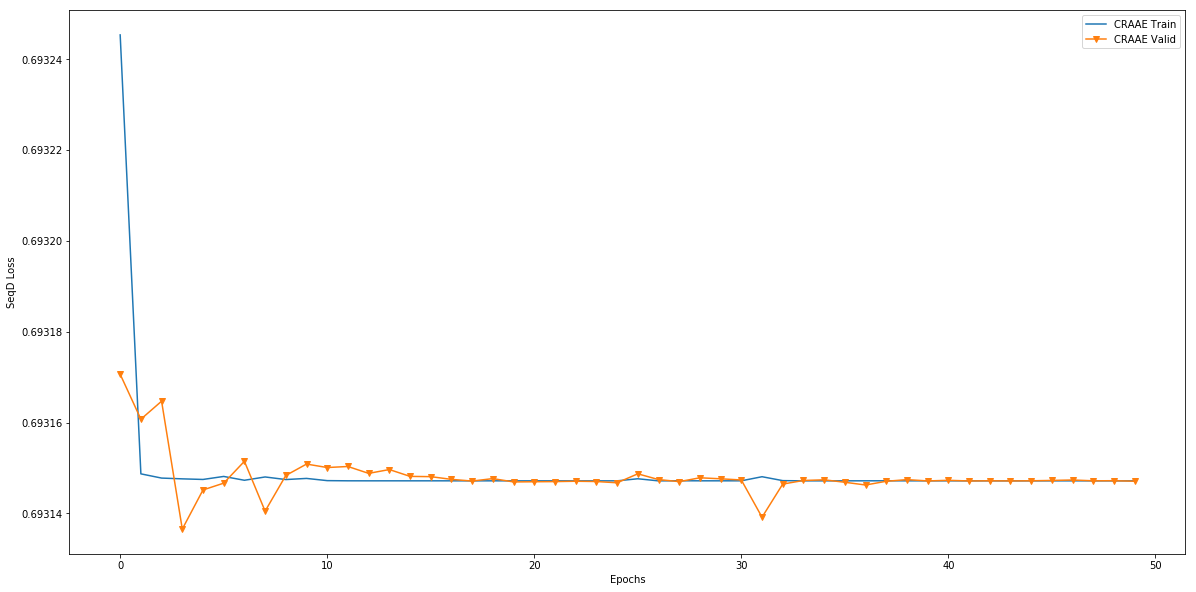

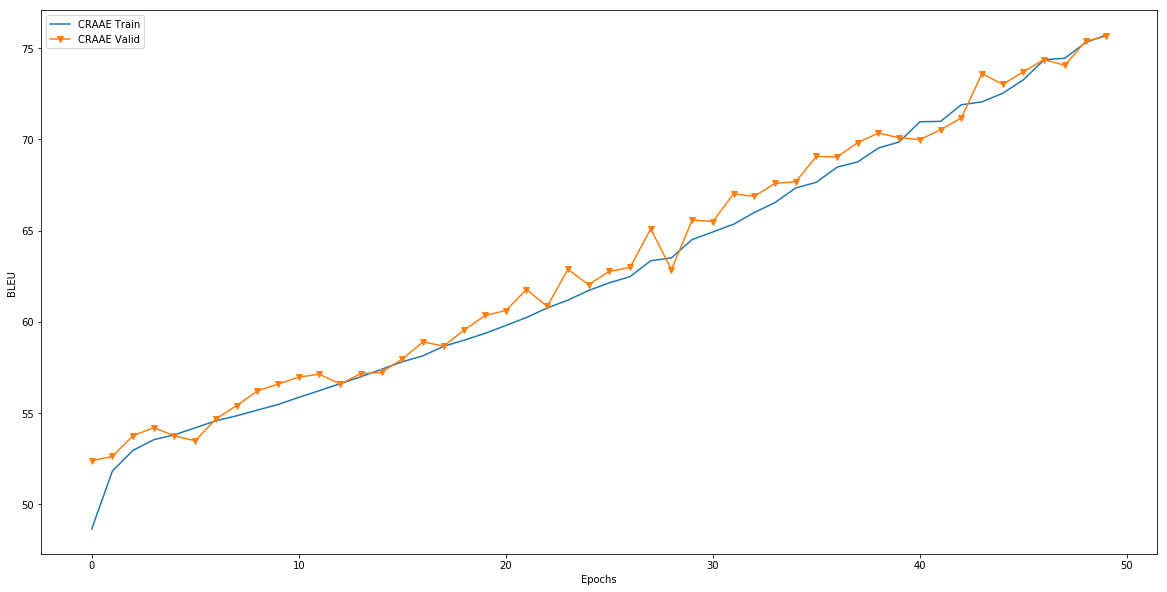

========== Start epoch 51 at 01:58:07 ==========
Epoch  51 Train: BLEU: 76.08, AE: 0.56938, G: 1.95448, ZD: 0.73653, SeqD: 0.69315  at 02:03:45
Epoch  51 Valid: BLEU: 75.97, AE: 0.86028, G: 2.28307, ZD: 0.68086, SeqD: 0.69315  at 02:03:51

Origin:  ['a black man and a large , golden dog are on the beach . <eos>']
Decoded: ['a black man and a large , golden dog are on the beach . <eos>']


Random sample:
	decoded w. style M: ['there young male as one jump through his mouth behind him . <eos>']
	decoded w. style E: ['sometimes it ai nt get me , there produced me up <eos>']

========== Start epoch 52 at 02:03:51 ==========
Epoch  52 Train: BLEU: 76.59, AE: 0.55281, G: 1.93442, ZD: 0.74424, SeqD: 0.69315  at 02:09:29
Epoch  52 Valid: BLEU: 76.65, AE: 0.83714, G: 2.23809, ZD: 0.70250, SeqD: 0.69315  at 02:09:35

Origin:  ['look , i was gon na go easy on you not to hurt your feelings <eos>']
Decoded: ['look , i was gon na make , a dude might let me , this fan']


Random sample:
	decoded w. s

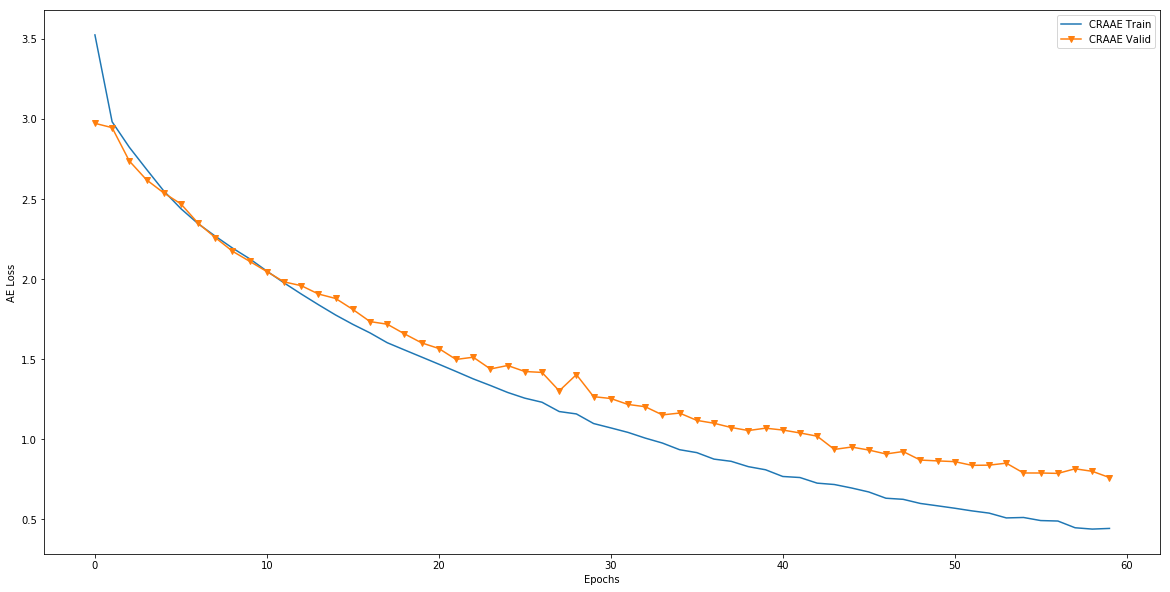

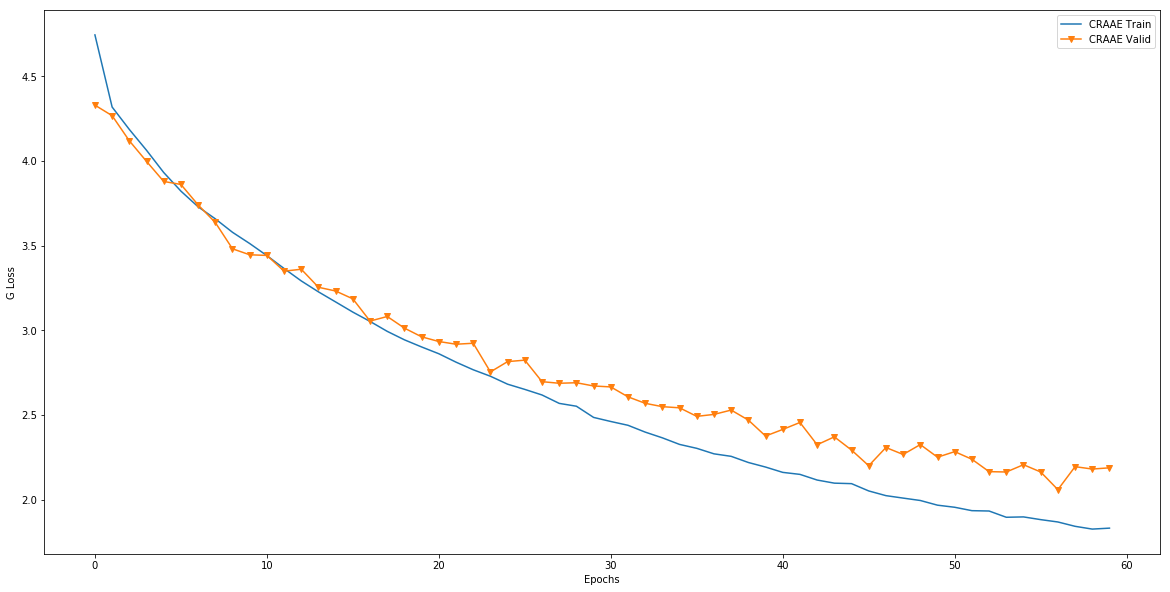

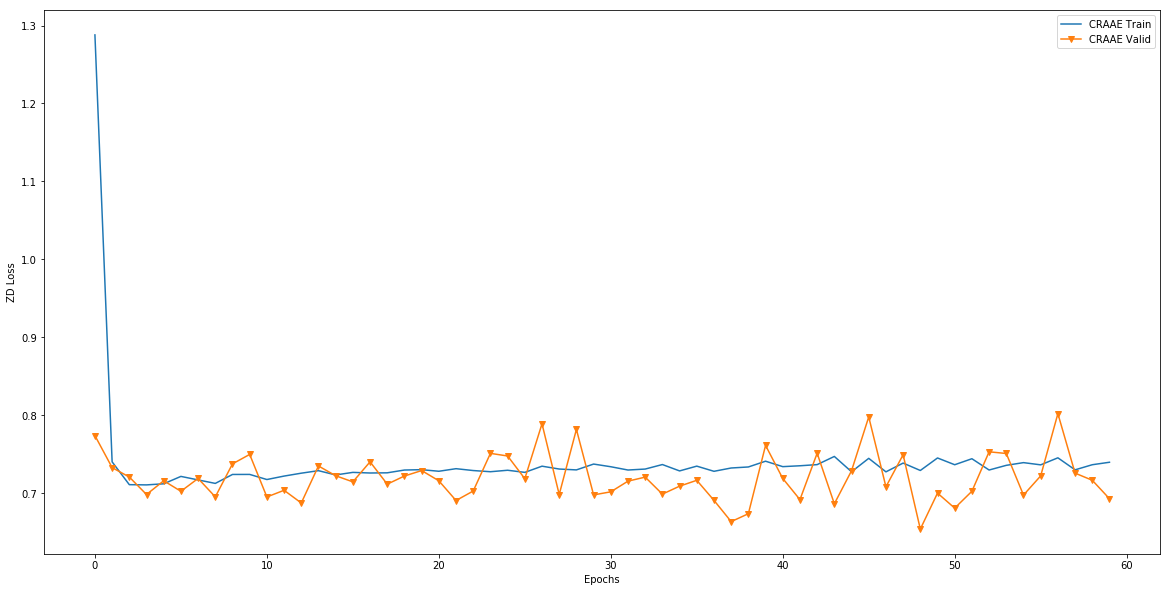

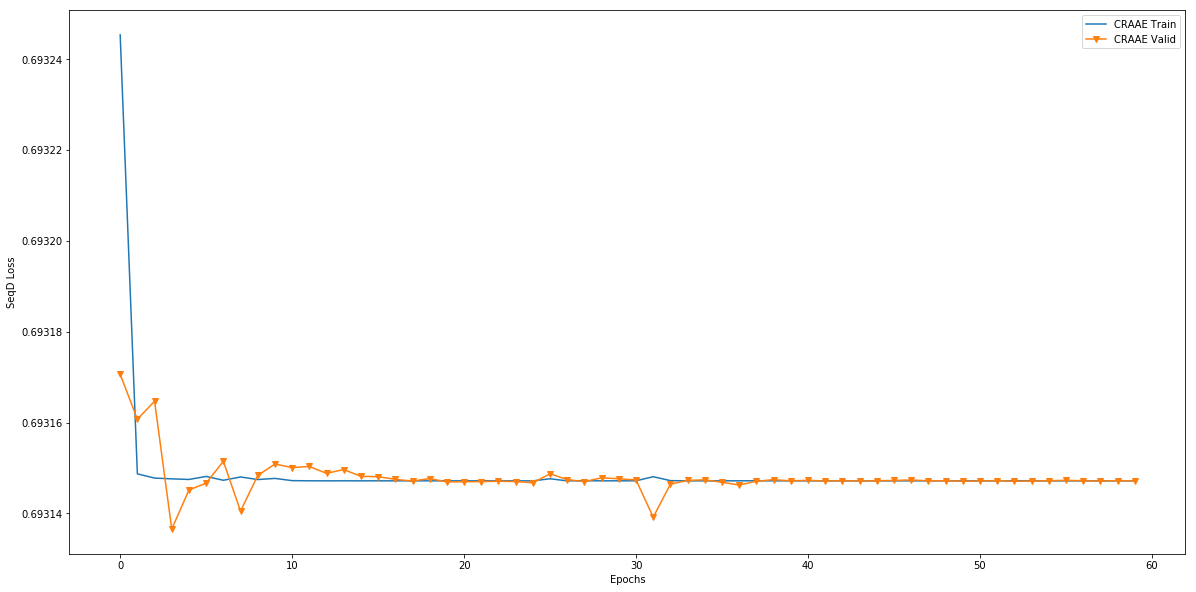

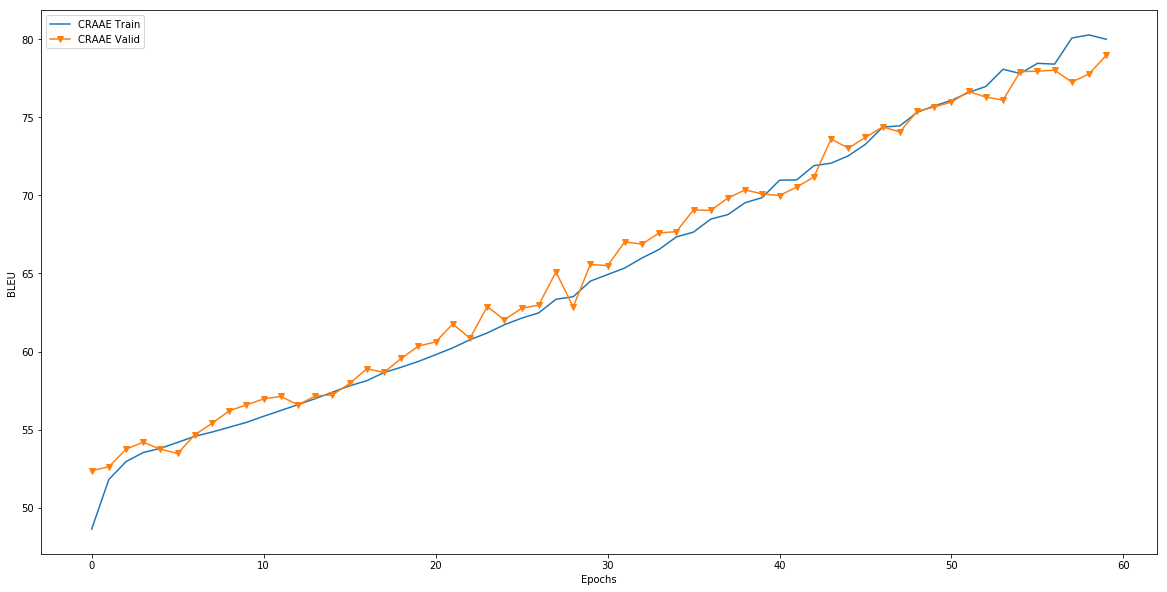

========== Start epoch 61 at 02:55:41 ==========
Epoch  61 Train: BLEU: 80.87, AE: 0.42076, G: 1.80500, ZD: 0.74179, SeqD: 0.69315  at 03:01:20
Epoch  61 Valid: BLEU: 79.50, AE: 0.74088, G: 2.12754, ZD: 0.72470, SeqD: 0.69315  at 03:01:26

Origin:  ['a human figure in a nature like costume standing as the center of attention at a party . <eos>']
Decoded: ['a caucasian squad on a beach rides and goggles takes photos from a ball at a party . <eos>']


Random sample:
	decoded w. style M: ['a man in orange shirt sweeping the electric bucket with sand behind him . <eos>']
	decoded w. style E: ['2 men playing on stage of his hands over him block candy . <eos>']

========== Start epoch 62 at 03:01:26 ==========
Epoch  62 Train: BLEU: 81.50, AE: 0.40319, G: 1.79265, ZD: 0.73336, SeqD: 0.69315  at 03:07:06
Epoch  62 Valid: BLEU: 78.20, AE: 0.77299, G: 2.05544, ZD: 0.78055, SeqD: 0.69315  at 03:07:13

Origin:  ['and ask him where the fuck did he get his damn raps from <eos>']
Decoded: ['and ask 

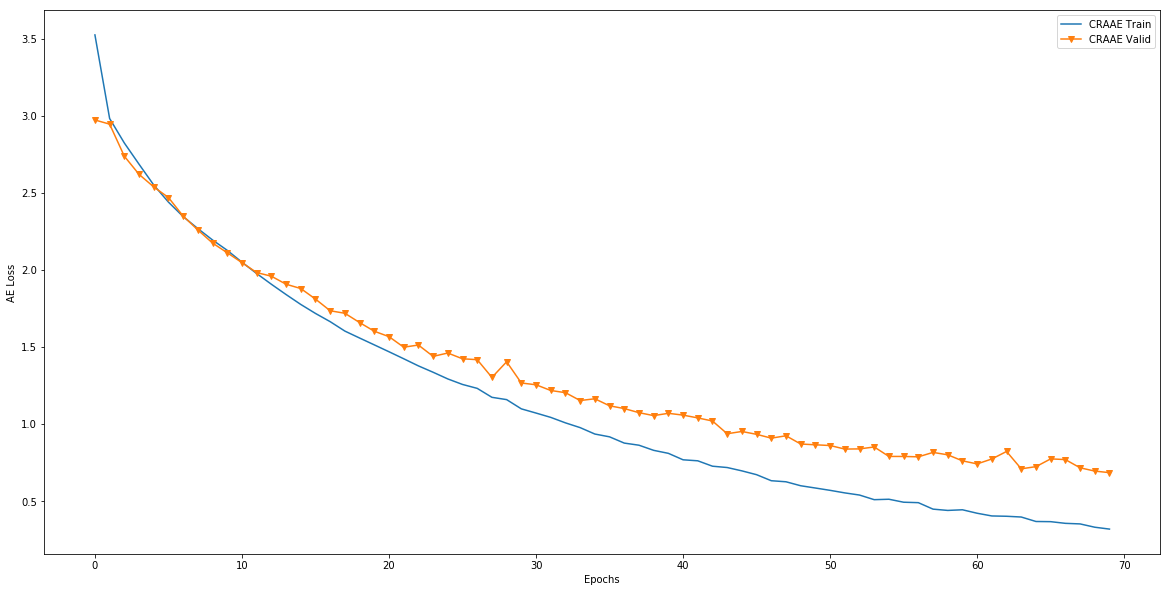

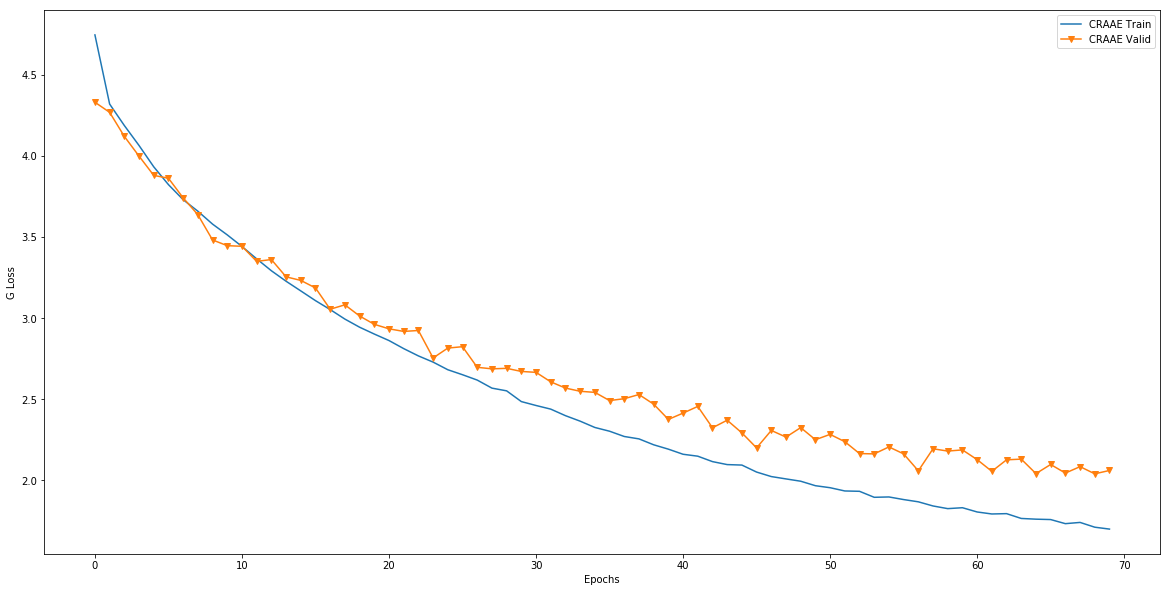

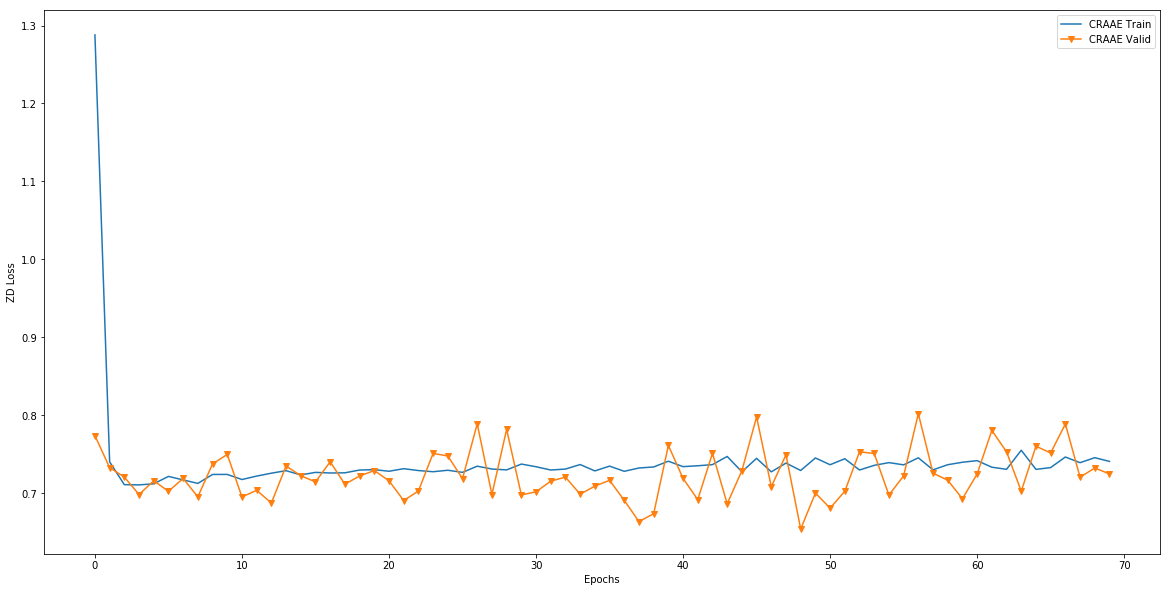

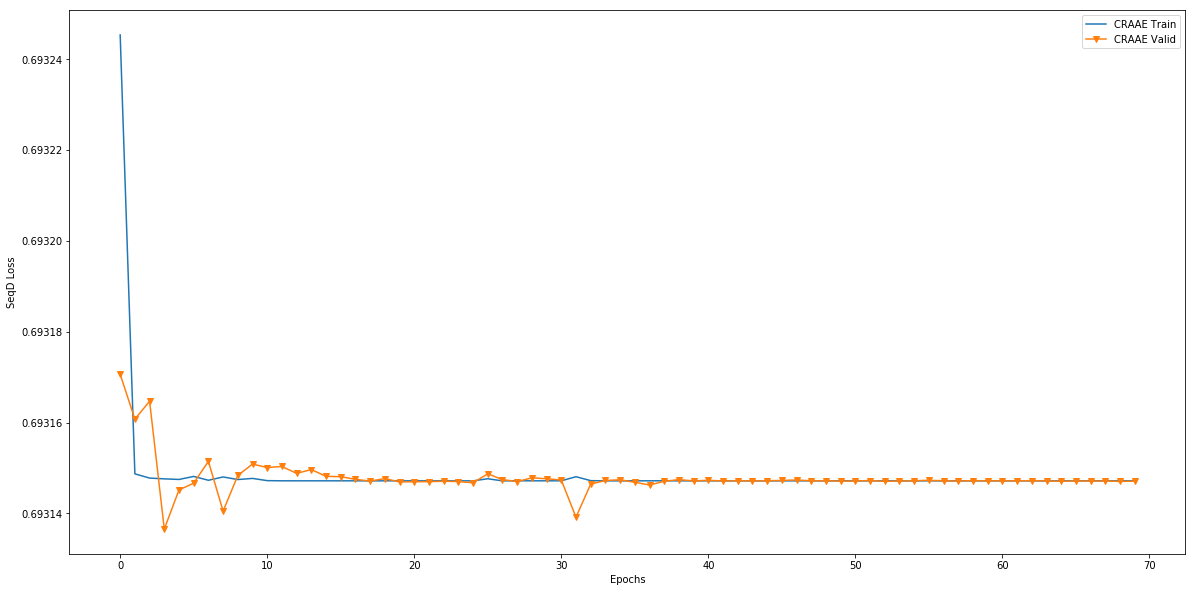

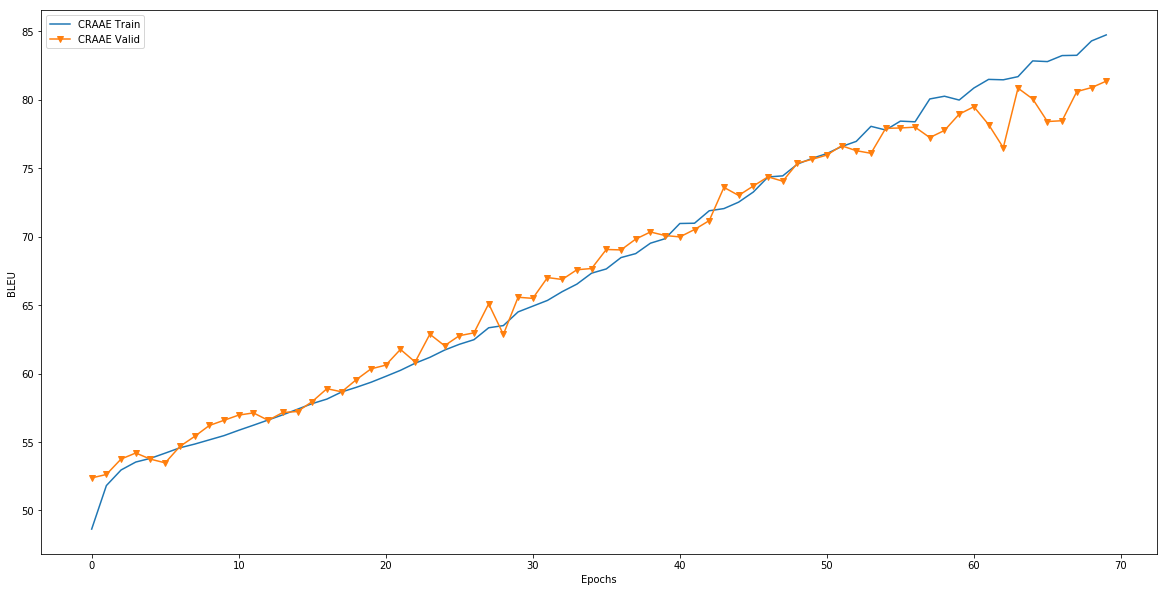

========== Start epoch 71 at 03:52:53 ==========
Epoch  71 Train: BLEU: 84.85, AE: 0.31266, G: 1.68826, ZD: 0.74513, SeqD: 0.69315  at 03:58:24
Epoch  71 Valid: BLEU: 82.49, AE: 0.65956, G: 2.08399, ZD: 0.70471, SeqD: 0.69315  at 03:58:30

Origin:  ['it hurts , but your jealousy probably tears you up inside as much <eos>']
Decoded: ['it hurts , but your jealousy probably tears you up inside as much <eos>']


Random sample:
	decoded w. style M: ['man with short pants with glasses into a sprinkler . <eos>']
	decoded w. style E: ['man at your skin and cranny about a goal . <eos>']

========== Start epoch 72 at 03:58:30 ==========
Epoch  72 Train: BLEU: 85.43, AE: 0.30112, G: 1.68345, ZD: 0.73995, SeqD: 0.69315  at 04:04:07
Epoch  72 Valid: BLEU: 82.02, AE: 0.67480, G: 2.09615, ZD: 0.70026, SeqD: 0.69315  at 04:04:13

Origin:  ['the passion and the flame is ignited <eos>']
Decoded: ['the passion and the flame is ignited <eos>']


Random sample:
	decoded w. style M: ['a woman uses flowers w

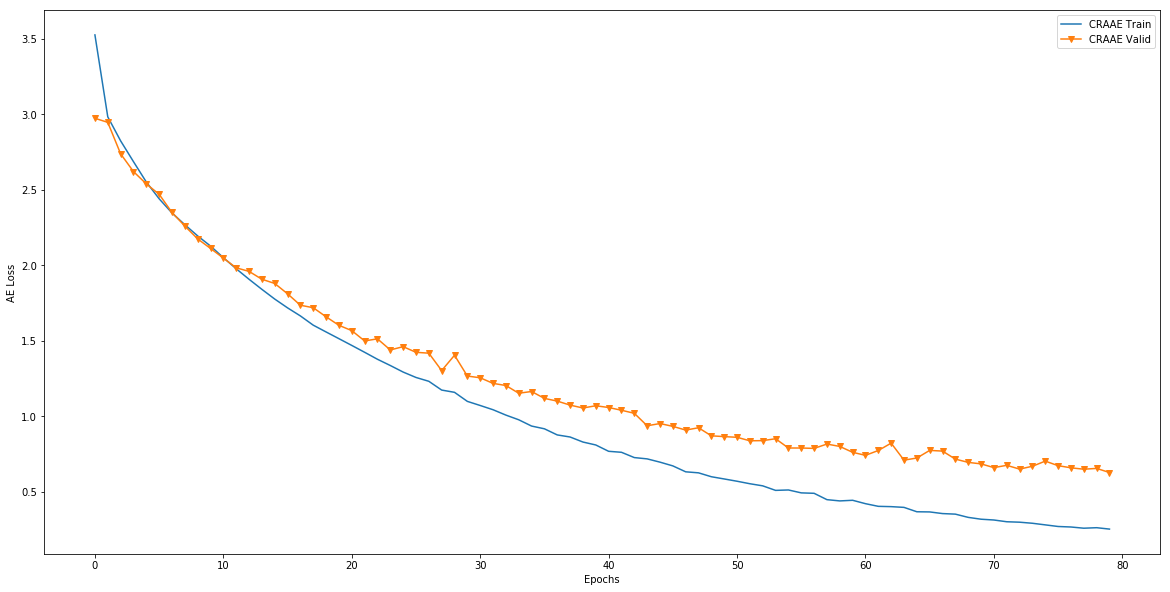

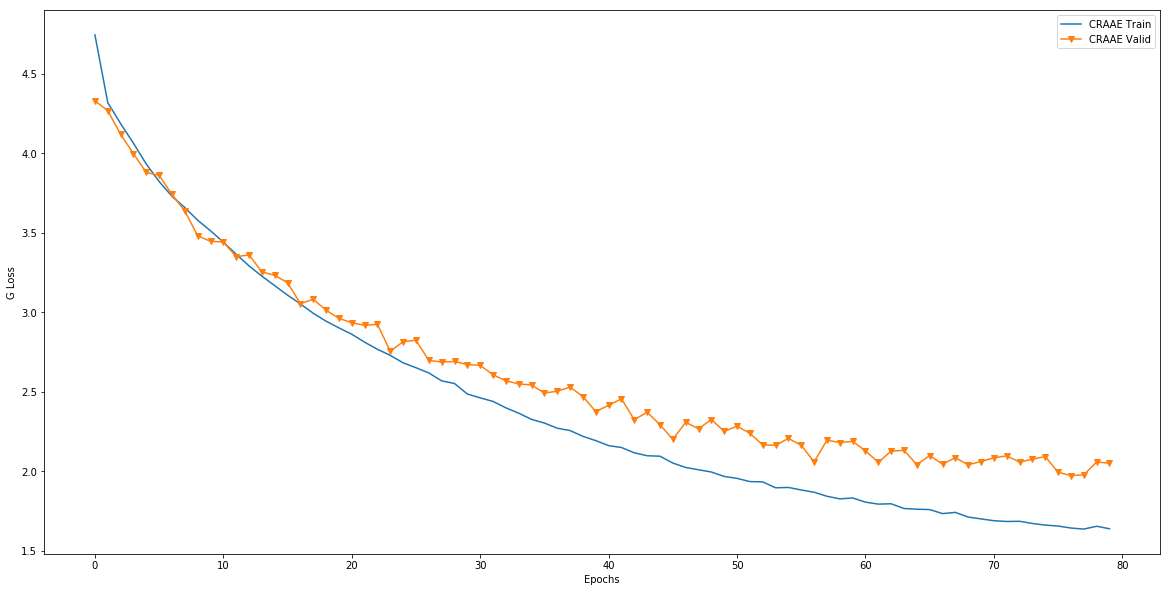

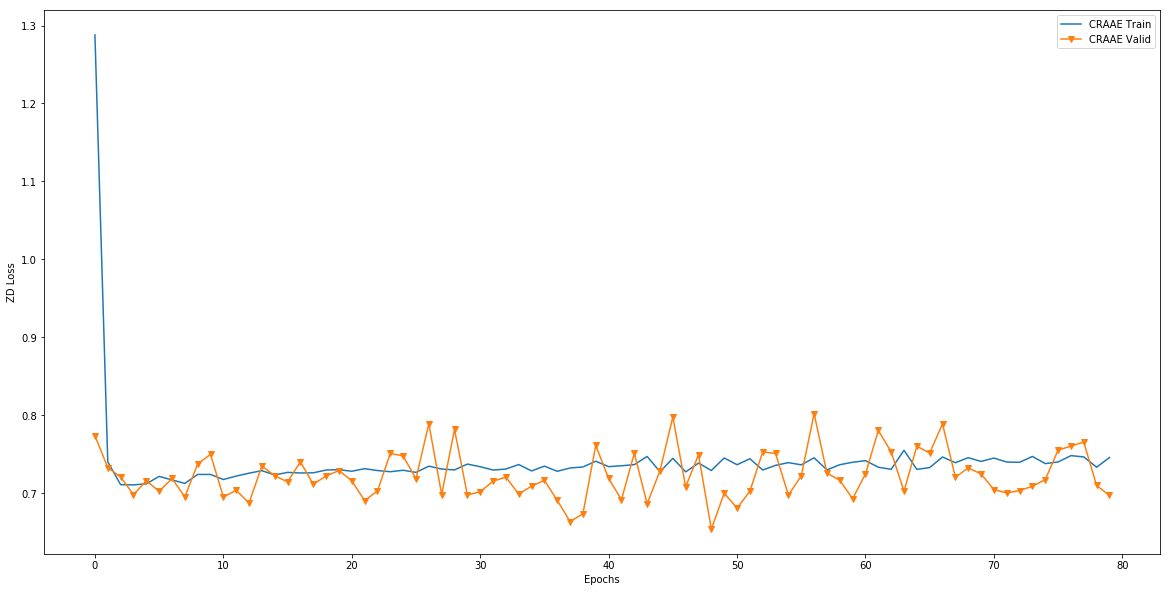

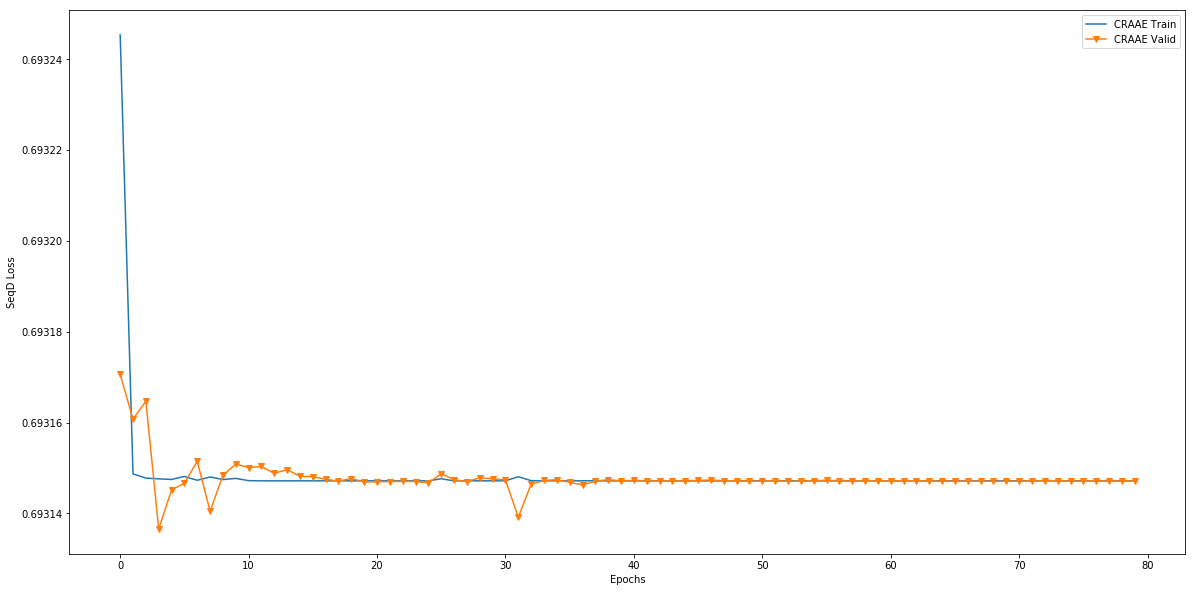

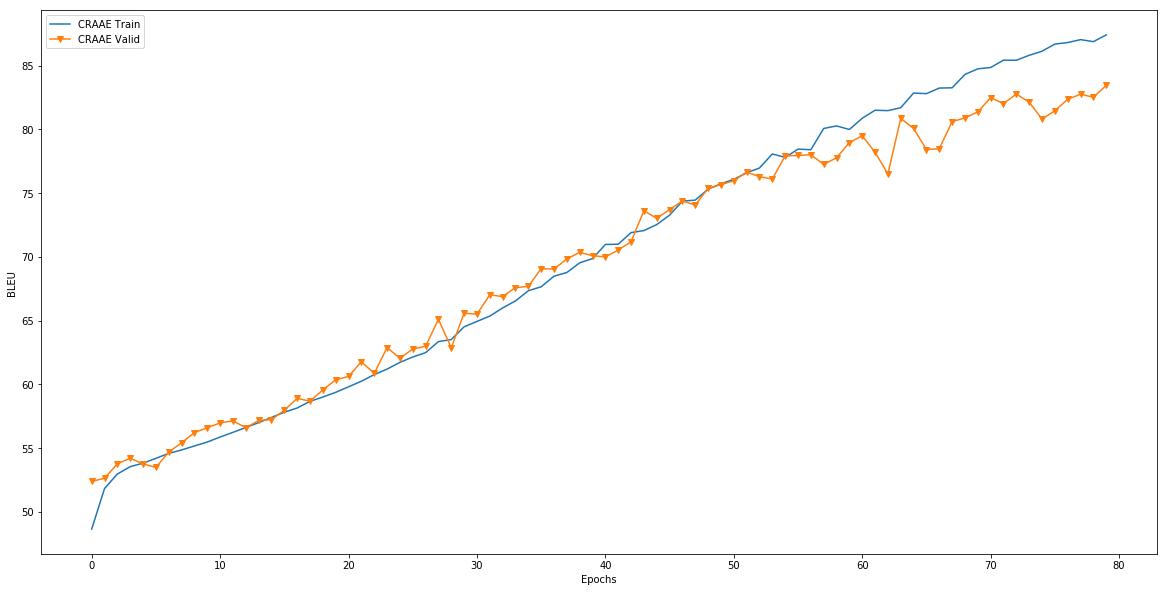

========== Start epoch 81 at 04:49:44 ==========
Epoch  81 Train: BLEU: 88.69, AE: 0.22776, G: 1.60164, ZD: 0.75072, SeqD: 0.69315  at 04:55:18
Epoch  81 Valid: BLEU: 83.46, AE: 0.62476, G: 1.97938, ZD: 0.73298, SeqD: 0.69315  at 04:55:24

Origin:  ['get some r and r and marinate in some marinara , <eos>']
Decoded: ['get some popcorn and running guns and down with they and <eos>']


Random sample:
	decoded w. style M: ['two black and yellow playing with mud with an background . <eos>']
	decoded w. style E: ['what s , a room wit fo here <eos>']

========== Start epoch 82 at 04:55:24 ==========
Epoch  82 Train: BLEU: 87.71, AE: 0.24152, G: 1.62551, ZD: 0.73735, SeqD: 0.69315  at 05:01:03
Epoch  82 Valid: BLEU: 82.97, AE: 0.63718, G: 1.93801, ZD: 0.77756, SeqD: 0.69315  at 05:01:09

Origin:  ["i said you do n't , wanna fuck with shady cause why ? <eos>"]
Decoded: ["i said you do n't , wanna fuck with shady cause why ? <eos>"]


Random sample:
	decoded w. style M: ['a naked boy with a red 

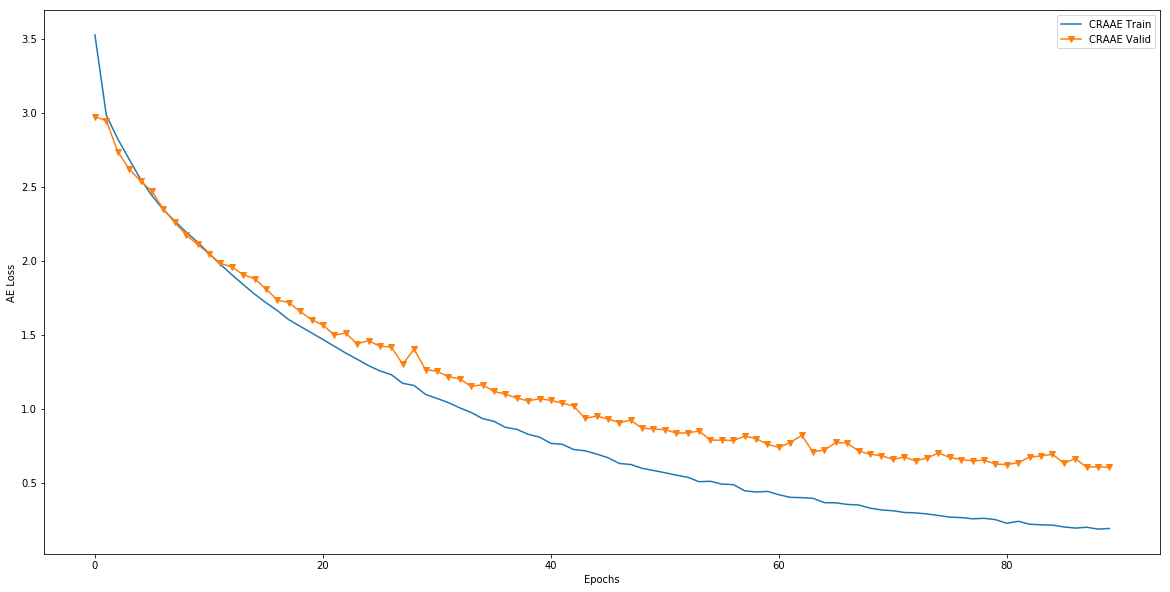

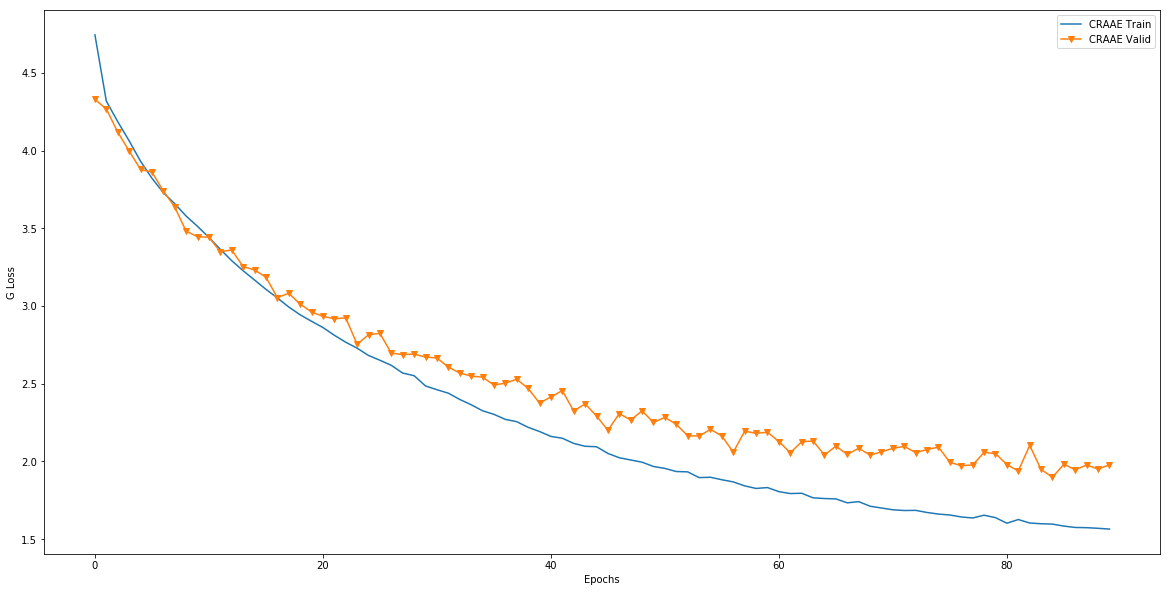

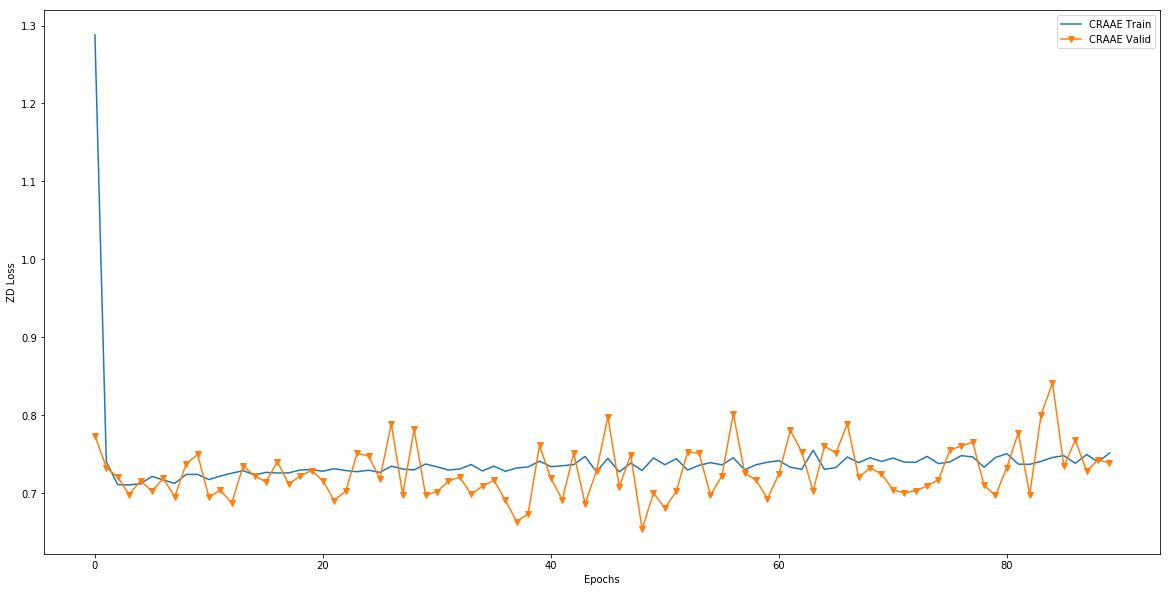

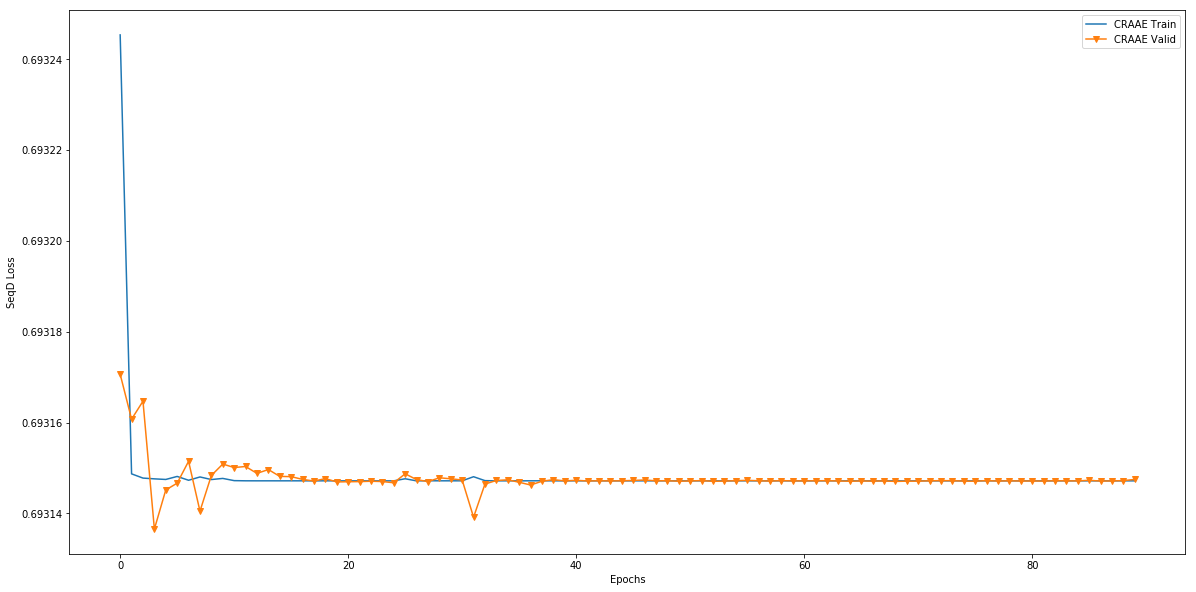

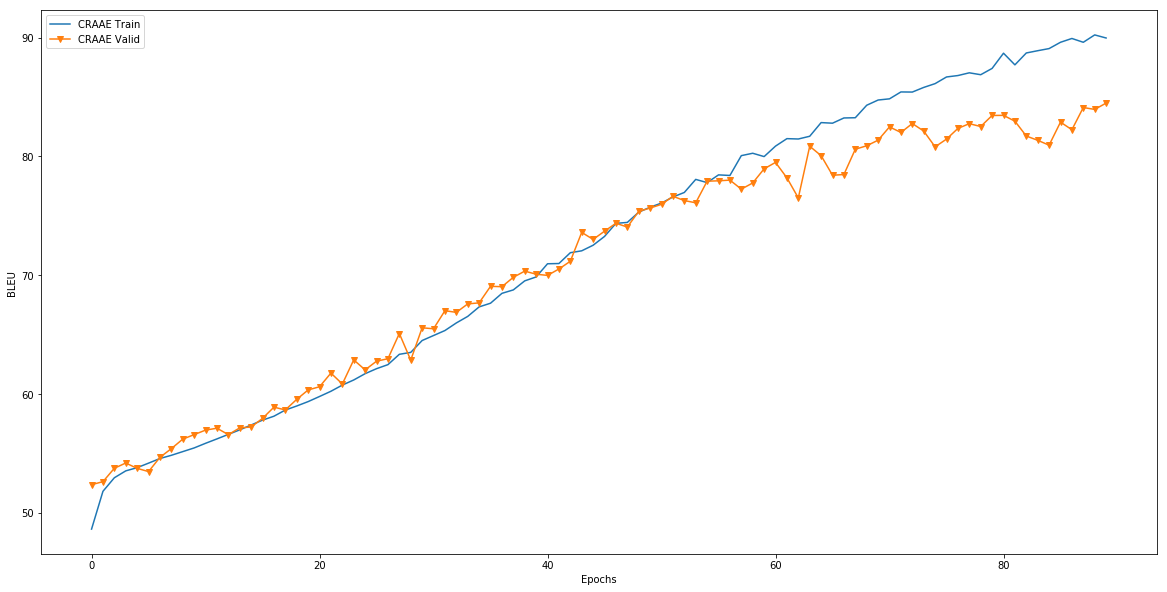

========== Start epoch 91 at 05:48:53 ==========
Epoch  91 Train: BLEU: 91.15, AE: 0.17177, G: 1.55800, ZD: 0.73466, SeqD: 0.69315  at 05:54:57
Epoch  91 Valid: BLEU: 84.35, AE: 0.60135, G: 1.95429, ZD: 0.73355, SeqD: 0.69315  at 05:55:05

Origin:  ['can he come back as nasty as he can <eos>']
Decoded: ['can he come back as nasty as he can explain']


Random sample:
	decoded w. style M: ['a track rider in this blond vest is crouched on the shore behind pictures of him sitting around him . <eos>']
	decoded w. style E: ["here about to fuckin you 're sayin ' also all that much like choppin ' dead skin me <eos>"]

========== Start epoch 92 at 05:55:05 ==========
Epoch  92 Train: BLEU: 90.99, AE: 0.17382, G: 1.55540, ZD: 0.73429, SeqD: 0.69315  at 06:01:12
Epoch  92 Valid: BLEU: 84.21, AE: 0.60606, G: 1.99126, ZD: 0.70934, SeqD: 0.69315  at 06:01:18

Origin:  ['woman kicking head of another kickboxer <eos>']
Decoded: ["woman kicking head of another skateboard 's"]


Random sample:
	decoded 

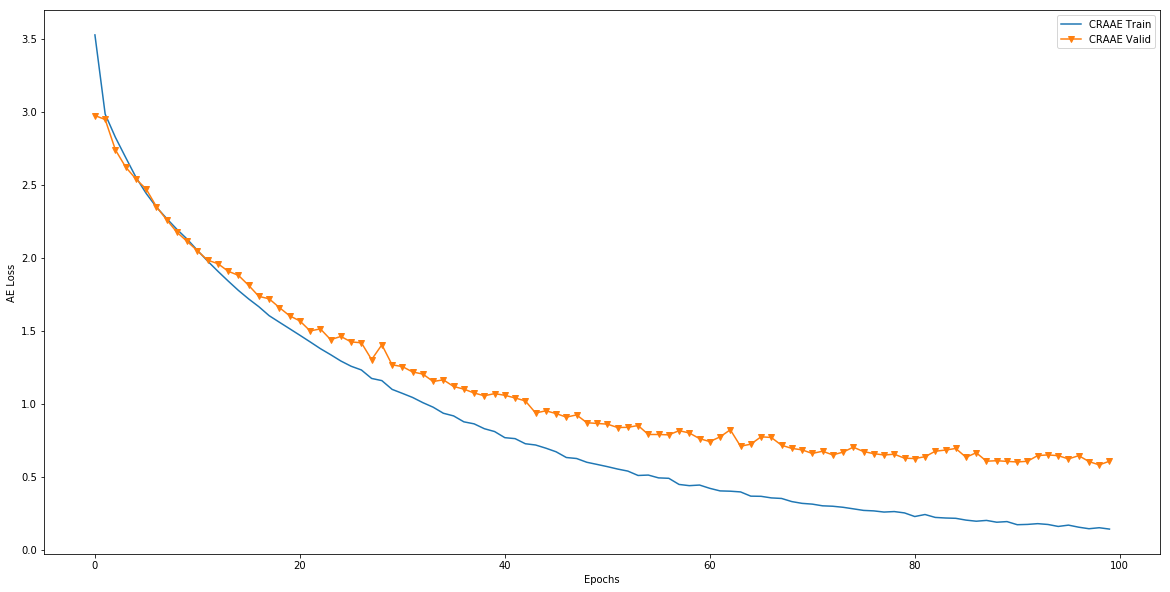

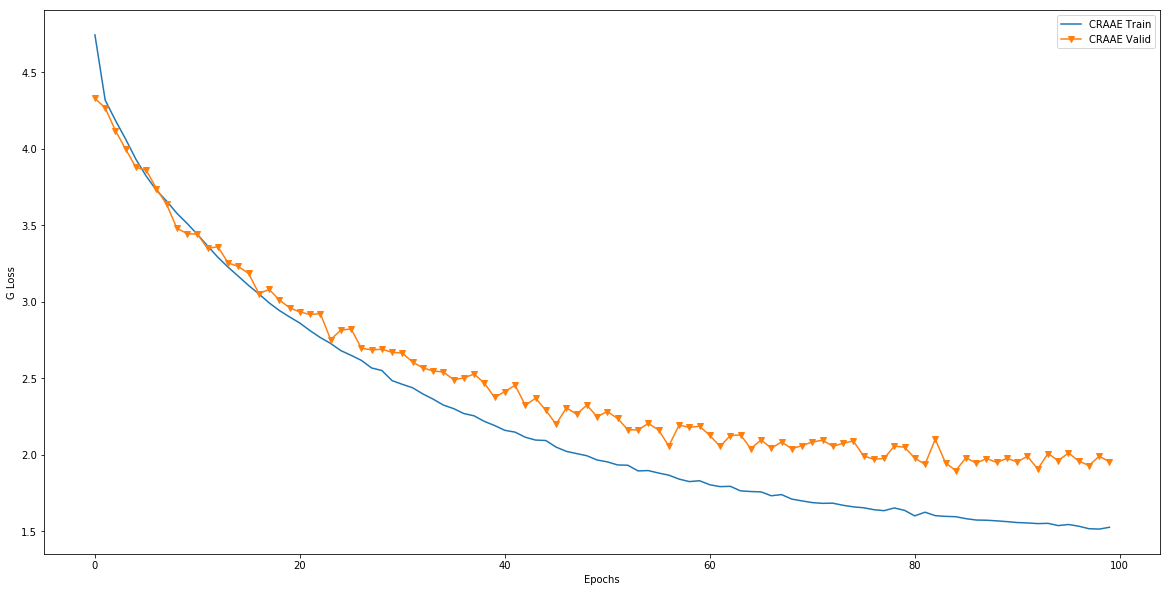

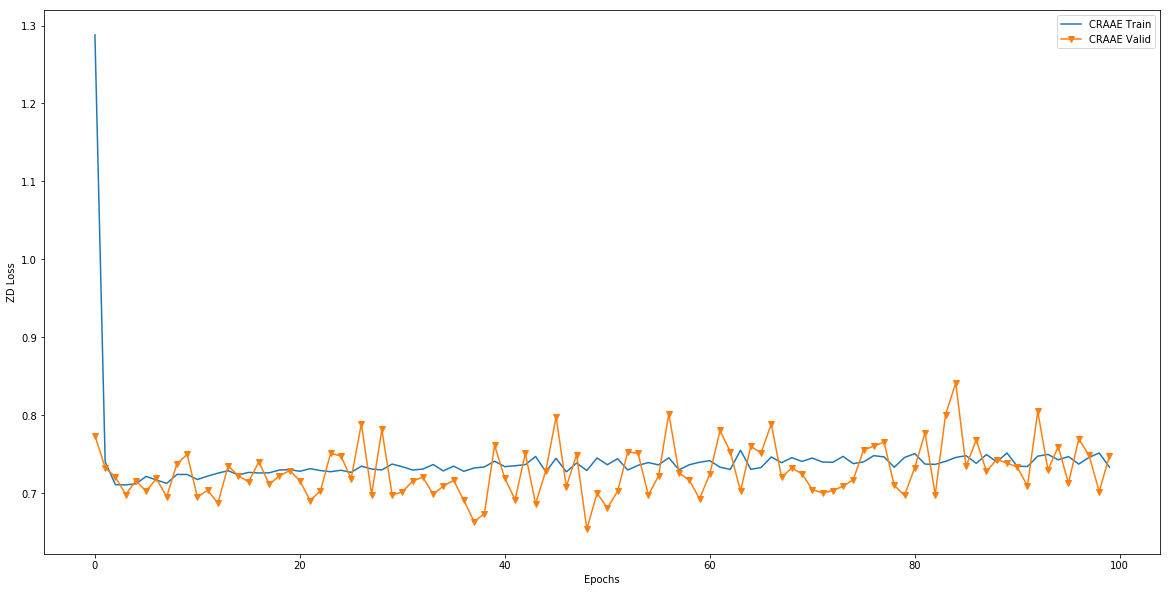

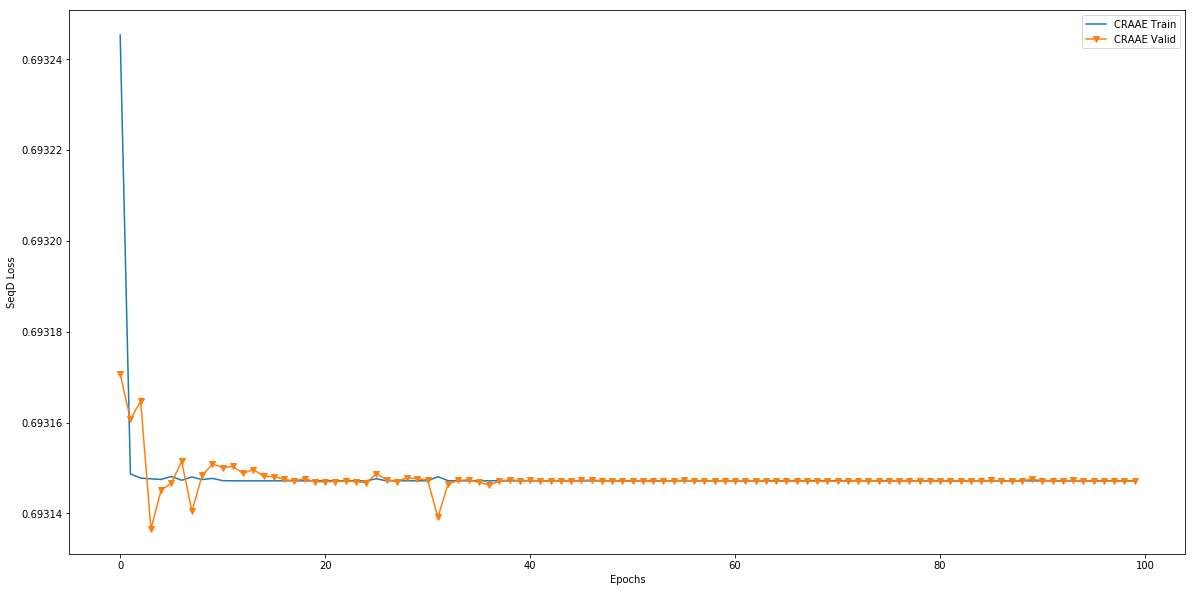

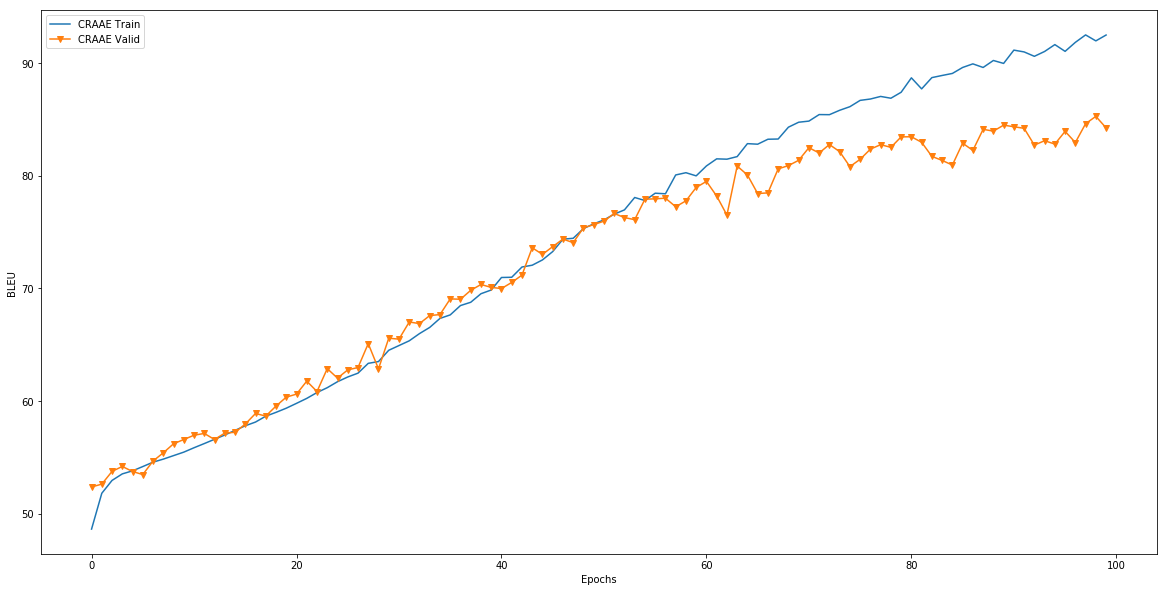

========== Start epoch 101 at 06:47:31 ==========
Epoch 101 Train: BLEU: 92.32, AE: 0.14374, G: 1.53897, ZD: 0.73030, SeqD: 0.69315  at 06:53:09
Epoch 101 Valid: BLEU: 84.45, AE: 0.59911, G: 1.95777, ZD: 0.72320, SeqD: 0.69315  at 06:53:15

Origin:  ['cut creator scratch the record with his fingernail <eos>']
Decoded: ['cut creator scratch the record with his skin <eos>']


Random sample:
	decoded w. style M: ['workers snowboarding along in the water side . <eos>']
	decoded w. style E: ['now come out because it <eos>']

========== Start epoch 102 at 06:53:16 ==========
Epoch 102 Train: BLEU: 92.01, AE: 0.14874, G: 1.50287, ZD: 0.76214, SeqD: 0.69315  at 06:58:52
Epoch 102 Valid: BLEU: 84.19, AE: 0.61500, G: 1.86557, ZD: 0.81337, SeqD: 0.69315  at 06:58:58

Origin:  ['five people are sitting together playing instruments . <eos>']
Decoded: ['five people are sitting together playing instruments . <eos>']


Random sample:
	decoded w. style M: ['one school player and wearing a are . <eos>']

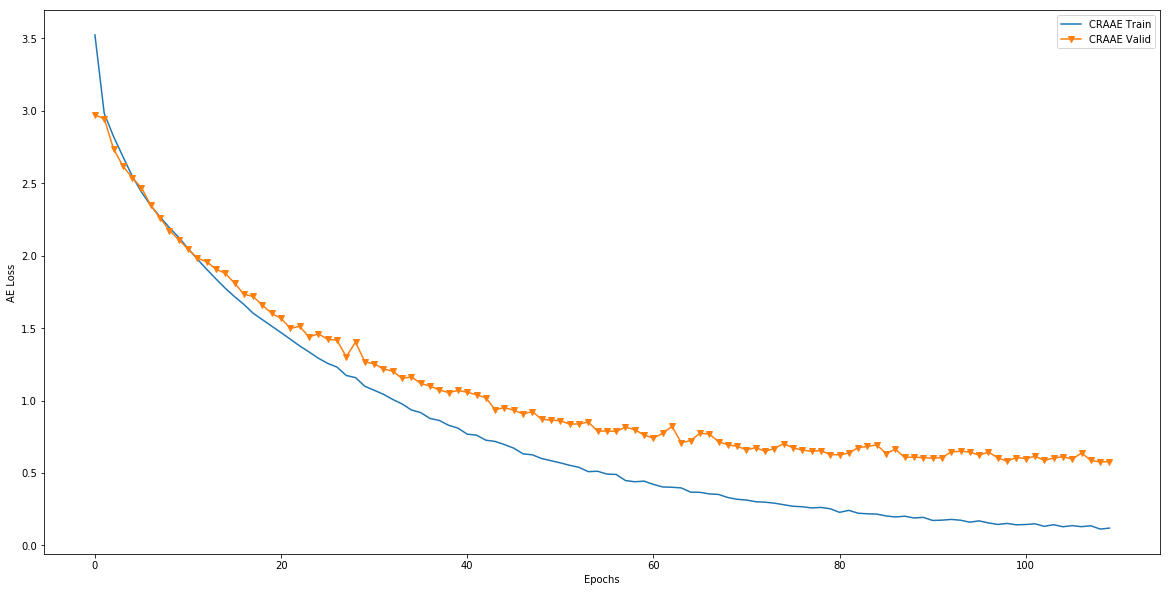

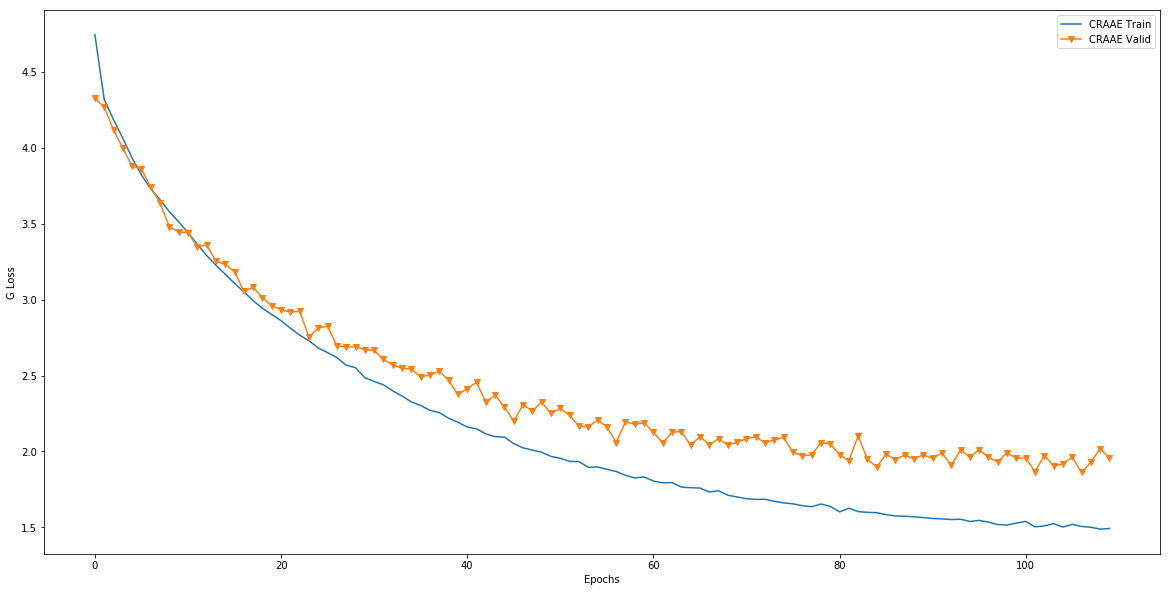

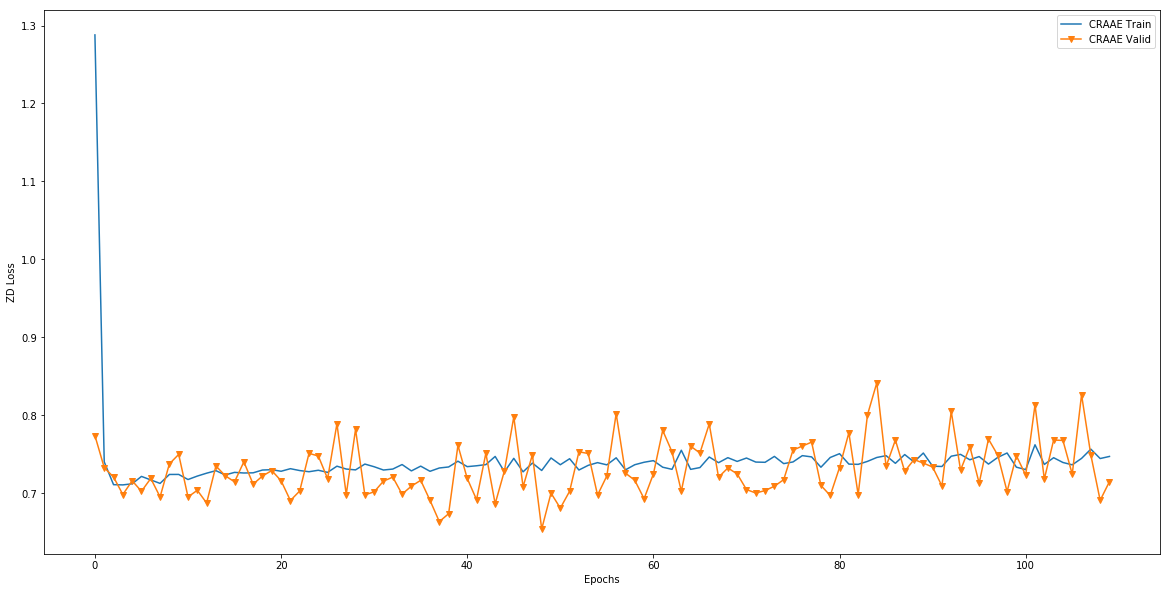

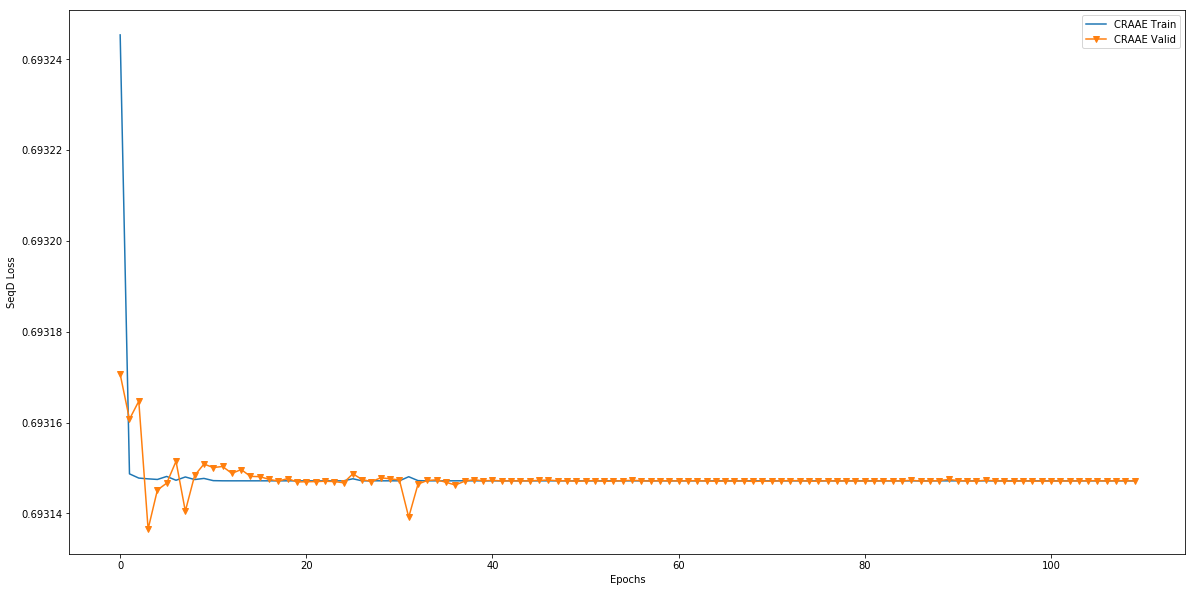

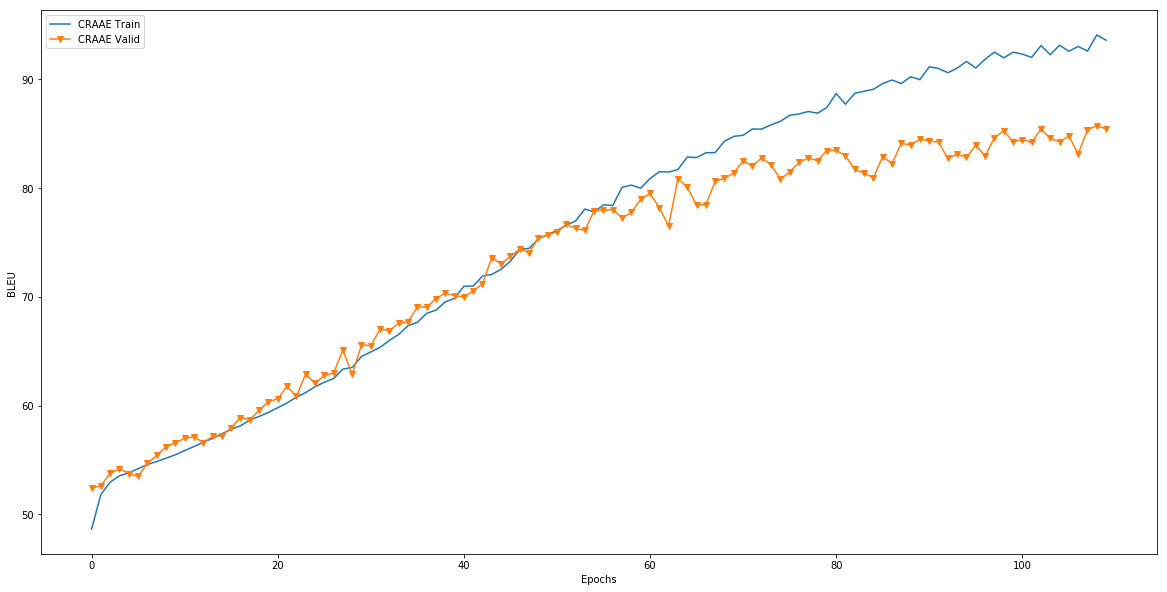

========== Start epoch 111 at 07:44:38 ==========
Epoch 111 Train: BLEU: 93.91, AE: 0.11310, G: 1.49521, ZD: 0.73465, SeqD: 0.69315  at 07:50:13
Epoch 111 Valid: BLEU: 84.90, AE: 0.59832, G: 2.00915, ZD: 0.70781, SeqD: 0.69315  at 07:50:19

Origin:  ['a young boy walking in the park dressed in dark clothes and dark cap . <eos>']
Decoded: ['a young boy walking in the park dressed in dark clothes and dark cap . <eos>']


Random sample:
	decoded w. style M: ['a orange dog standing on the grass . <eos>']
	decoded w. style E: ['throwing a bad in the saga <eos>']

========== Start epoch 112 at 07:50:19 ==========
Epoch 112 Train: BLEU: 93.73, AE: 0.11520, G: 1.48304, ZD: 0.74808, SeqD: 0.69315  at 07:55:52
Epoch 112 Valid: BLEU: 84.78, AE: 0.60353, G: 1.91827, ZD: 0.76420, SeqD: 0.69315  at 07:55:58

Origin:  ['a brown haired lady smiles at the camera in front of trees . <eos>']
Decoded: ['a brown haired lady smiles at the camera in front of trees . <eos>']


Random sample:
	decoded w. style

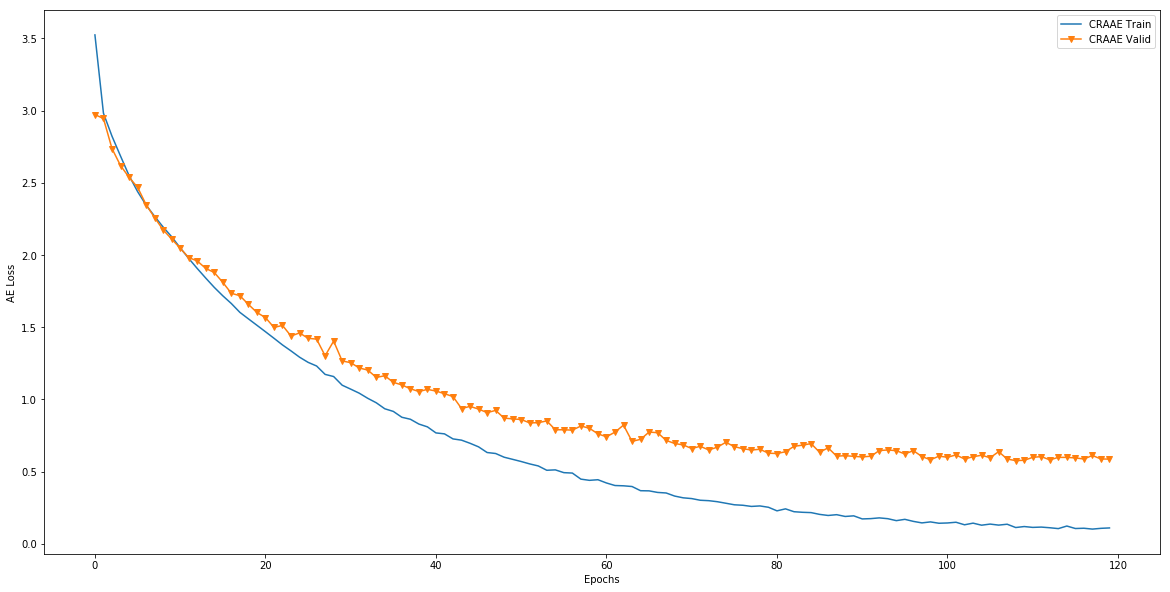

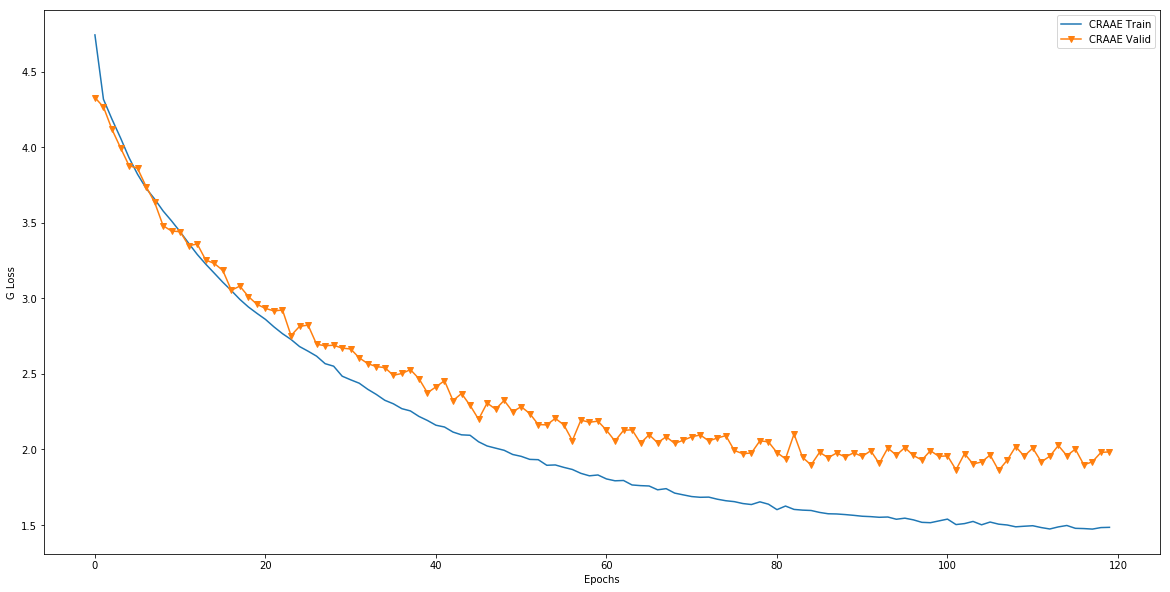

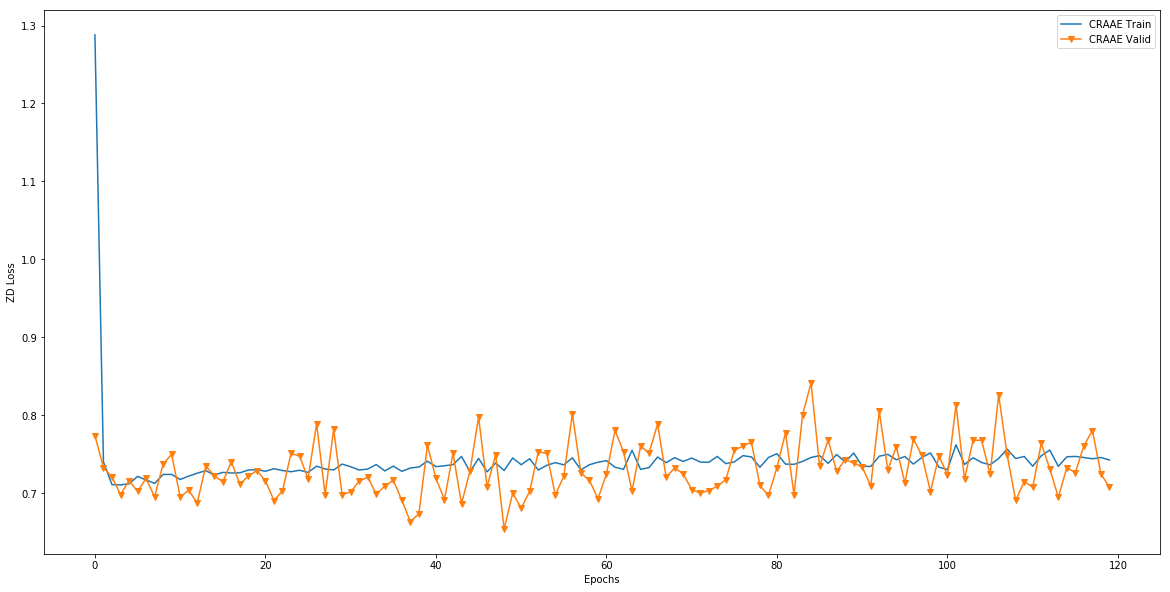

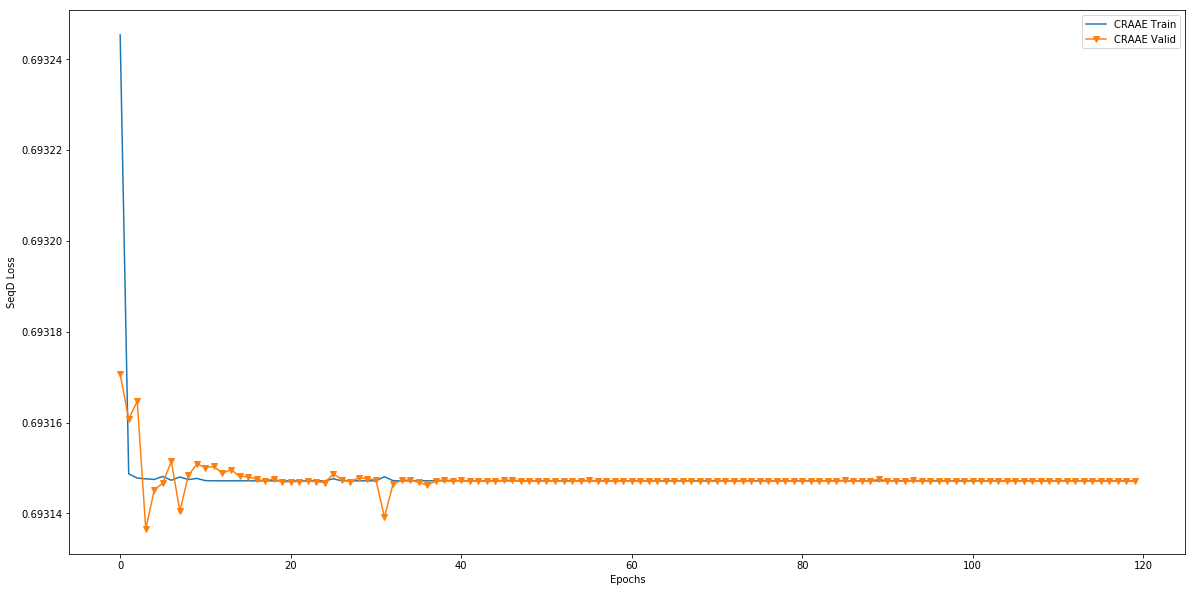

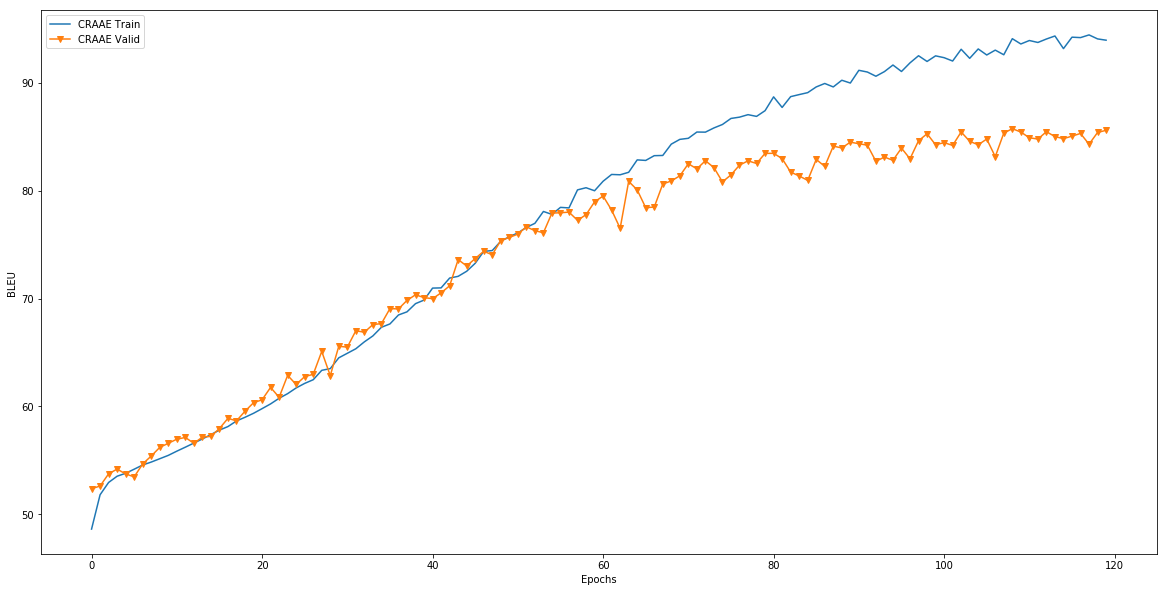

========== Start epoch 121 at 08:40:59 ==========
Epoch 121 Train: BLEU: 94.52, AE: 0.09968, G: 1.47318, ZD: 0.74597, SeqD: 0.69315  at 08:46:28
Epoch 121 Valid: BLEU: 86.05, AE: 0.56984, G: 1.99265, ZD: 0.69314, SeqD: 0.69315  at 08:46:34

Origin:  ['two bicyclists in spandex and helmets in a race pedaling uphill . <eos>']
Decoded: ['two bicyclists in spandex and helmets in a race pedaling uphill . <eos>']


Random sample:
	decoded w. style M: ['the airplane of boston tennis game . <eos>']
	decoded w. style E: ['i´ve even out slim , <eos>']

========== Start epoch 122 at 08:46:34 ==========
Epoch 122 Train: BLEU: 93.84, AE: 0.10875, G: 1.50288, ZD: 0.73031, SeqD: 0.69315  at 08:52:08
Epoch 122 Valid: BLEU: 85.11, AE: 0.60091, G: 1.95217, ZD: 0.72331, SeqD: 0.69315  at 08:52:13

Origin:  ['several people are dancing in a crowded room . <eos>']
Decoded: ['several people are dancing in a crowded room . <eos>']


Random sample:
	decoded w. style M: ['bmx biker rider on a skate path in the

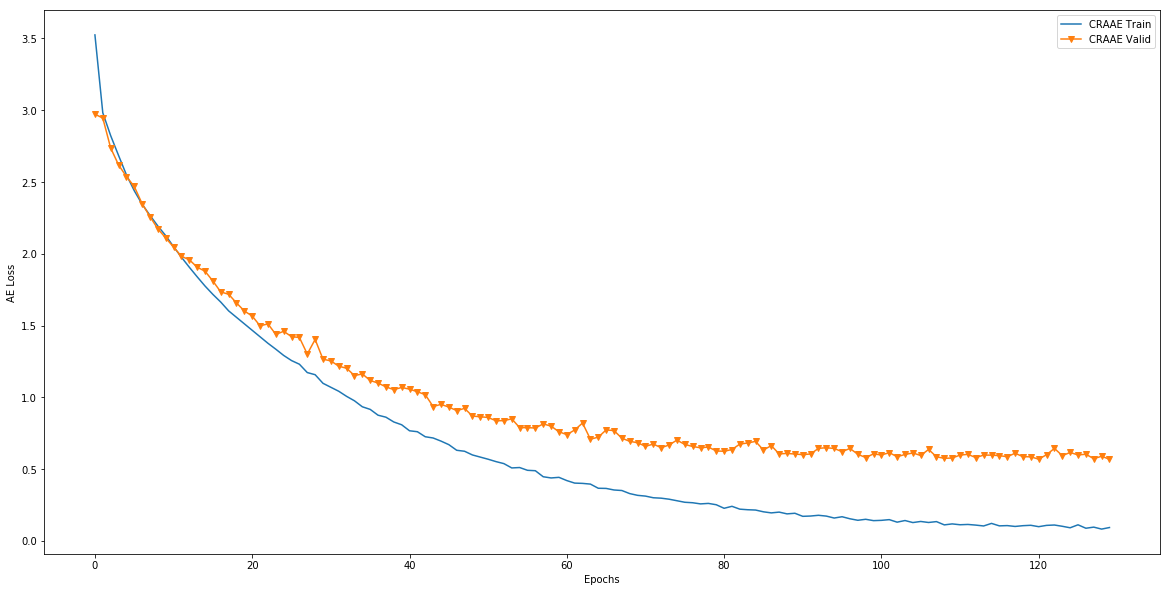

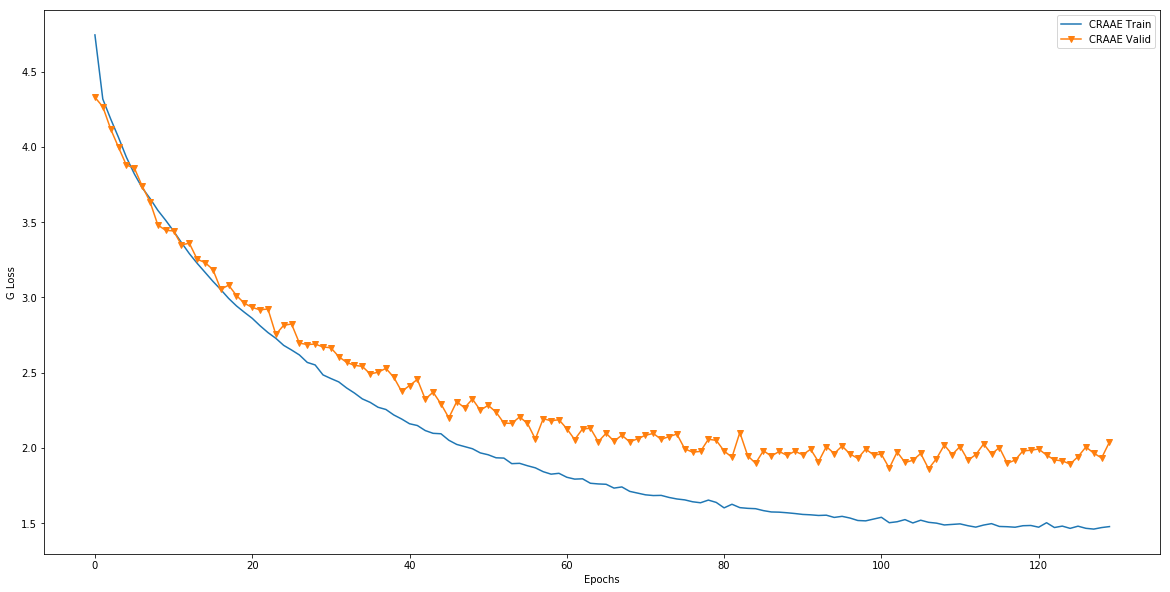

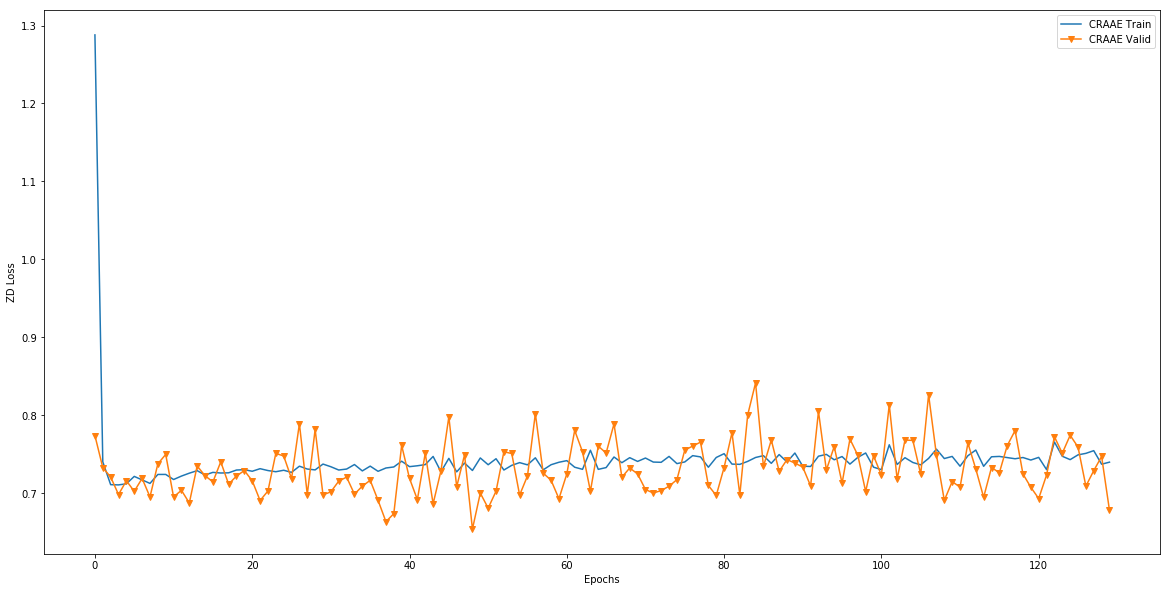

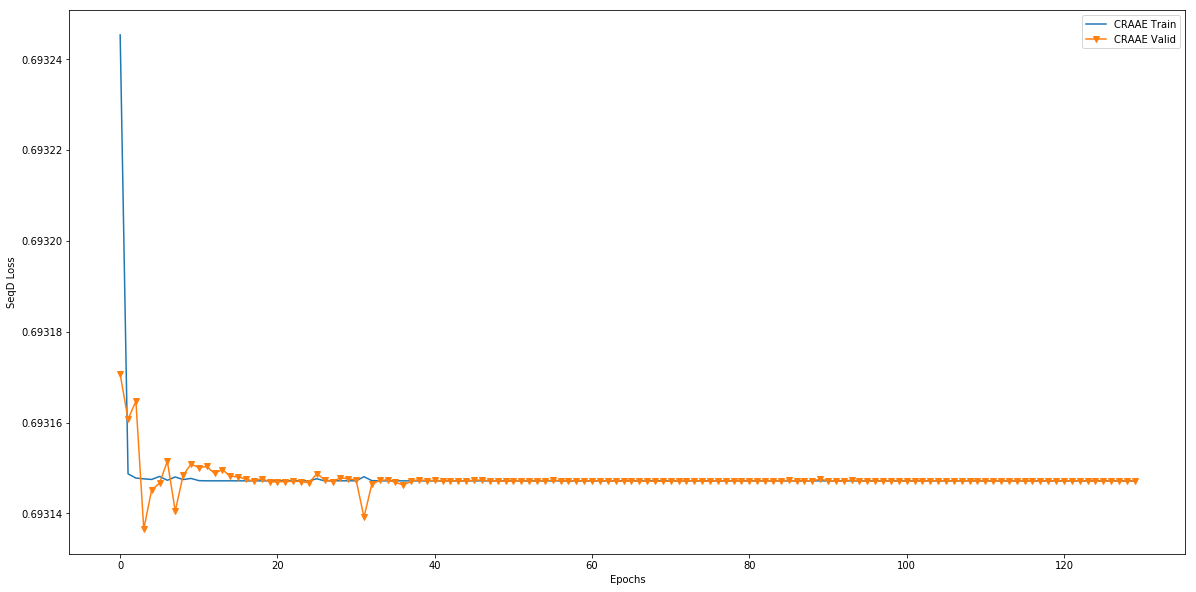

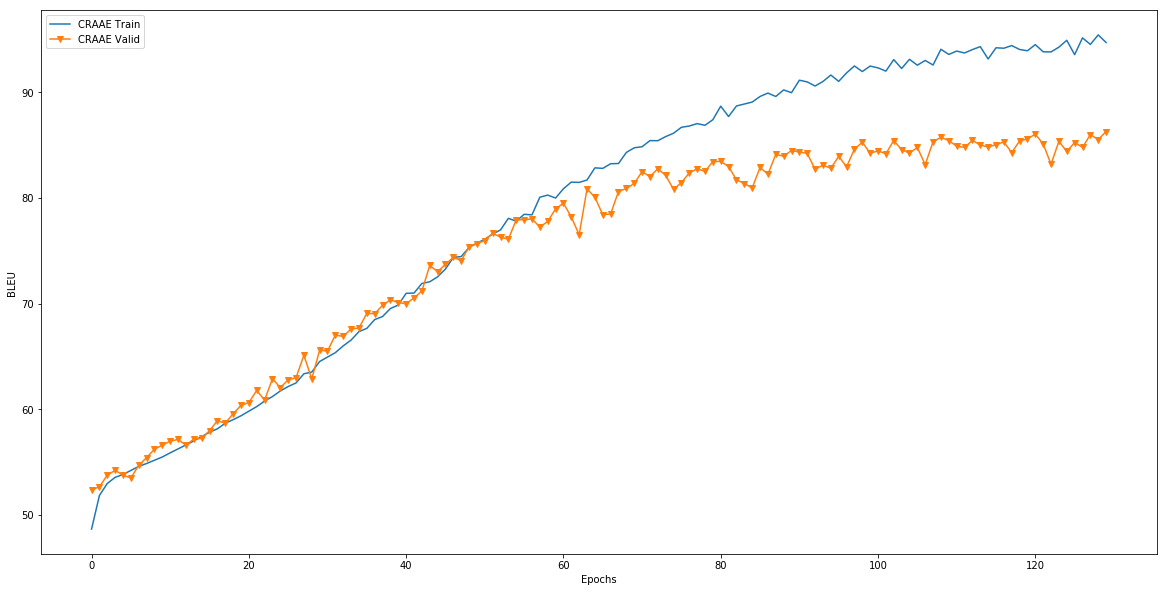

========== Start epoch 131 at 09:37:33 ==========
Epoch 131 Train: BLEU: 94.56, AE: 0.09471, G: 1.46943, ZD: 0.74070, SeqD: 0.69315  at 09:43:31
Epoch 131 Valid: BLEU: 86.14, AE: 0.57656, G: 1.94983, ZD: 0.71345, SeqD: 0.69315  at 09:43:37

Origin:  ["ai n't nobody who 's as good at what i do <eos>"]
Decoded: ["ai n't nobody who 's as good at what i do <eos>"]


Random sample:
	decoded w. style M: ['a man with track boots in a paddle field one . <eos>']
	decoded w. style E: ["duba ' , posted up heavy into another background <eos>"]

========== Start epoch 132 at 09:43:38 ==========
Epoch 132 Train: BLEU: 94.67, AE: 0.09285, G: 1.46306, ZD: 0.74545, SeqD: 0.69315  at 09:49:25
Epoch 132 Valid: BLEU: 85.98, AE: 0.57540, G: 1.86360, ZD: 0.78985, SeqD: 0.69315  at 09:49:31

Origin:  ['a woman holds a man by the collar on a curbside as a bus approaches on the street . <eos>']
Decoded: ['a woman holds a man by the face on a curbside as a bus approaches on the street . <eos>']


Random sample:

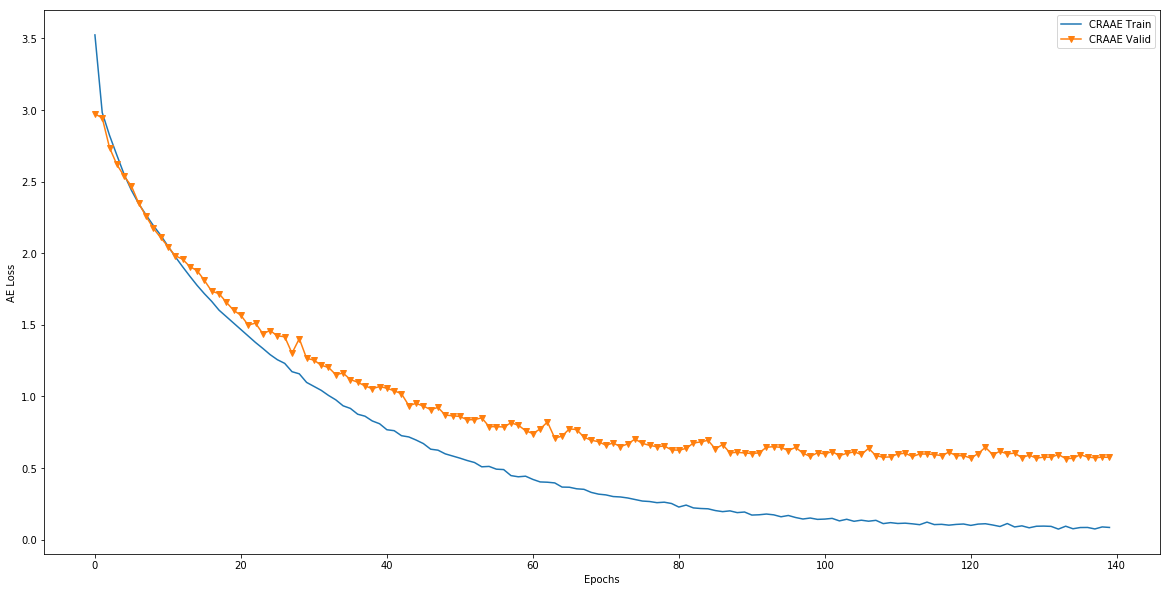

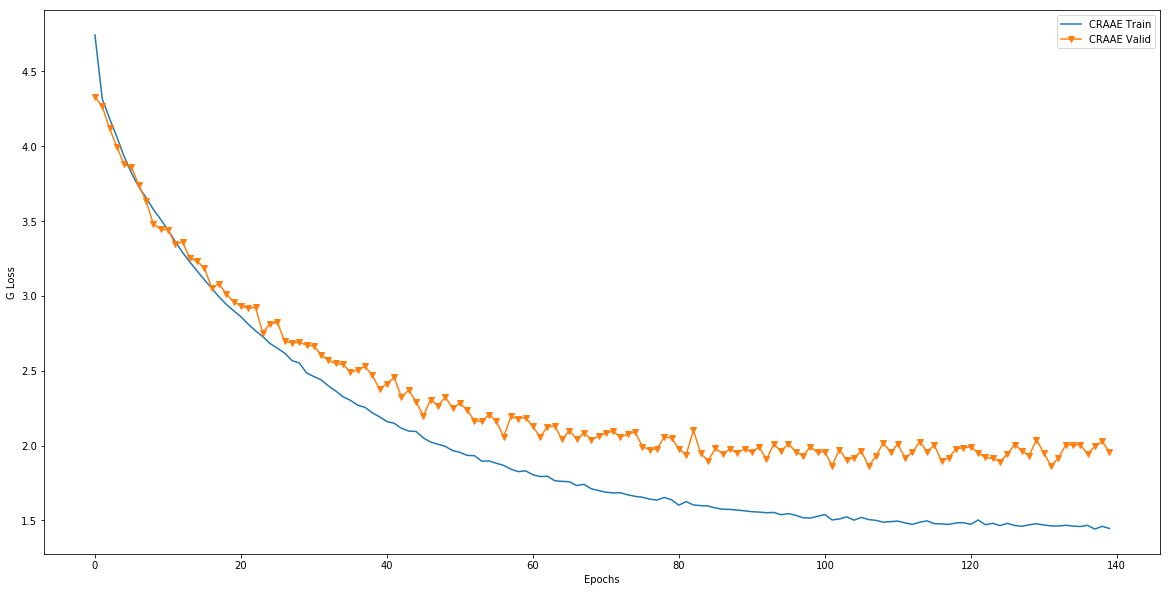

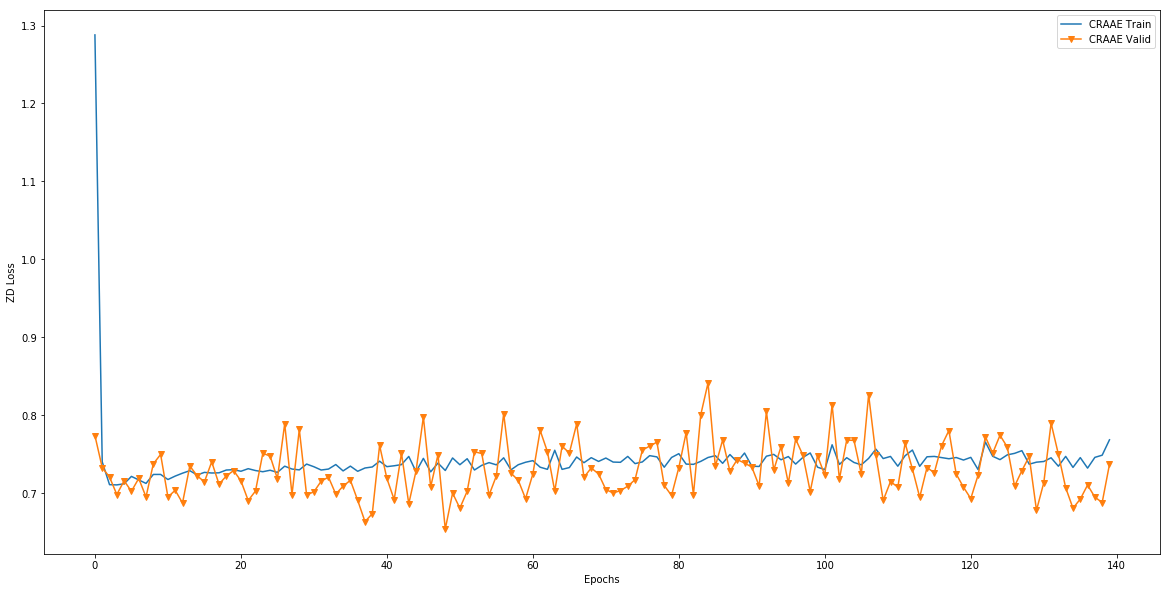

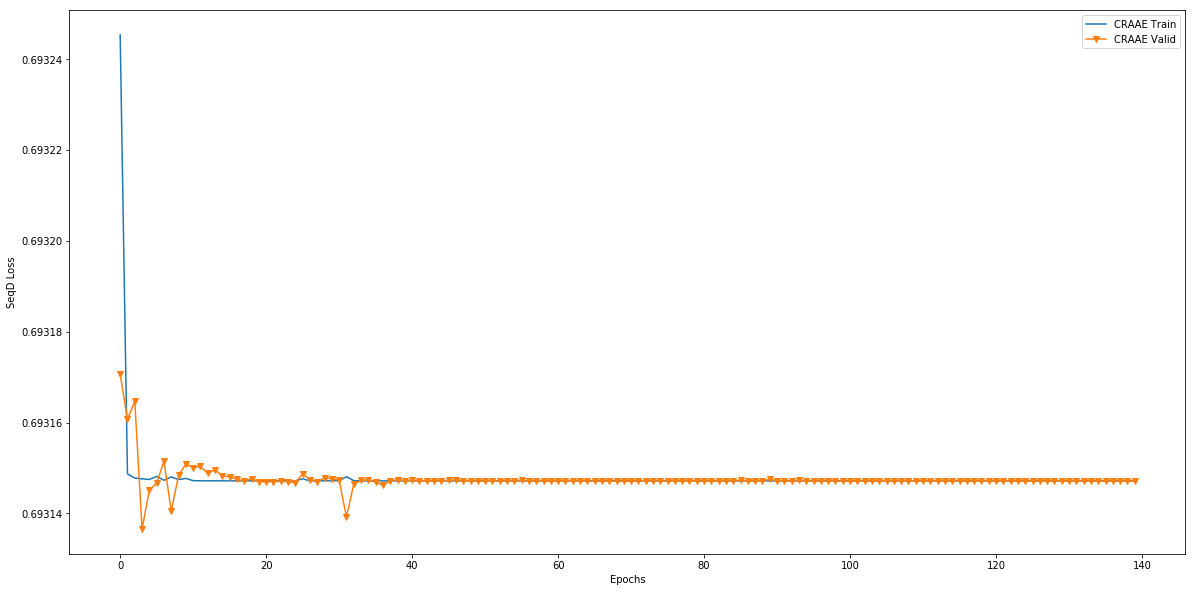

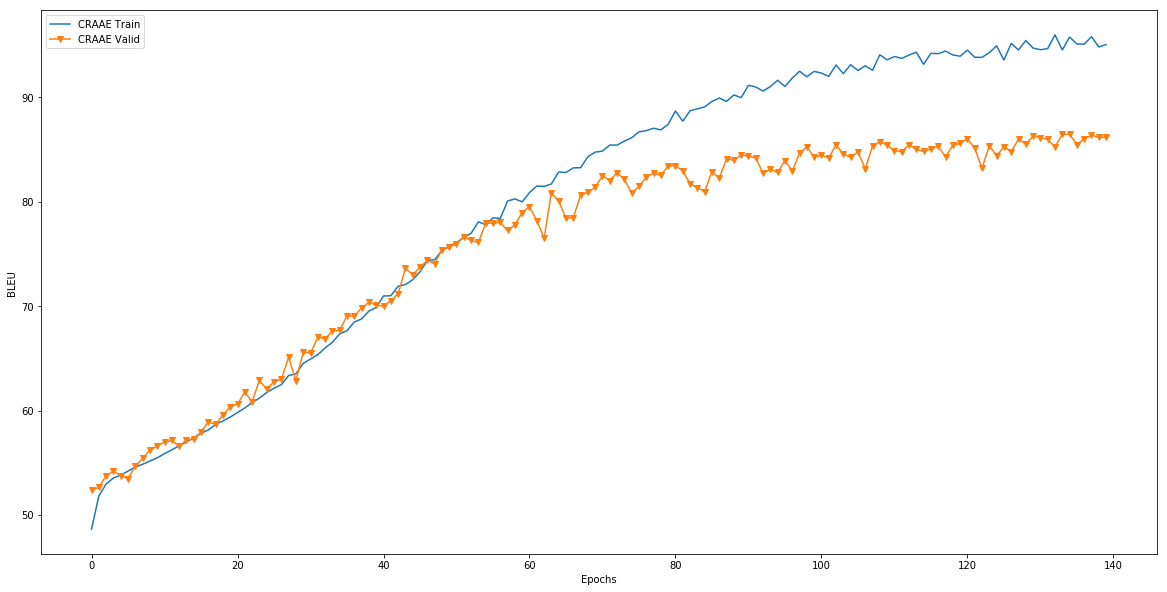

========== Start epoch 141 at 10:35:54 ==========
Epoch 141 Train: BLEU: 96.38, AE: 0.06655, G: 1.45258, ZD: 0.73473, SeqD: 0.69315  at 10:41:32
Epoch 141 Valid: BLEU: 86.42, AE: 0.56842, G: 2.00870, ZD: 0.69791, SeqD: 0.69315  at 10:41:38

Origin:  ['people working together to secure a ceiling panel . <eos>']
Decoded: ['people working together to secure a ceiling panel . <eos>']


Random sample:
	decoded w. style M: ['the people of patron and growing up plates . <eos>']
	decoded w. style E: ['the only side calling deep with ease up my corners <eos>']

========== Start epoch 142 at 10:41:38 ==========
Epoch 142 Train: BLEU: 95.57, AE: 0.07692, G: 1.46634, ZD: 0.73093, SeqD: 0.69315  at 10:47:12
Epoch 142 Valid: BLEU: 85.78, AE: 0.59055, G: 1.98661, ZD: 0.73036, SeqD: 0.69315  at 10:47:18

Origin:  ['someone in a rain jacket pushes a yellow bag on wheels down the sidewalk . <eos>']
Decoded: ['someone in a rain jacket pushes a yellow bag on wheels down the sidewalk . <eos>']


Random sam

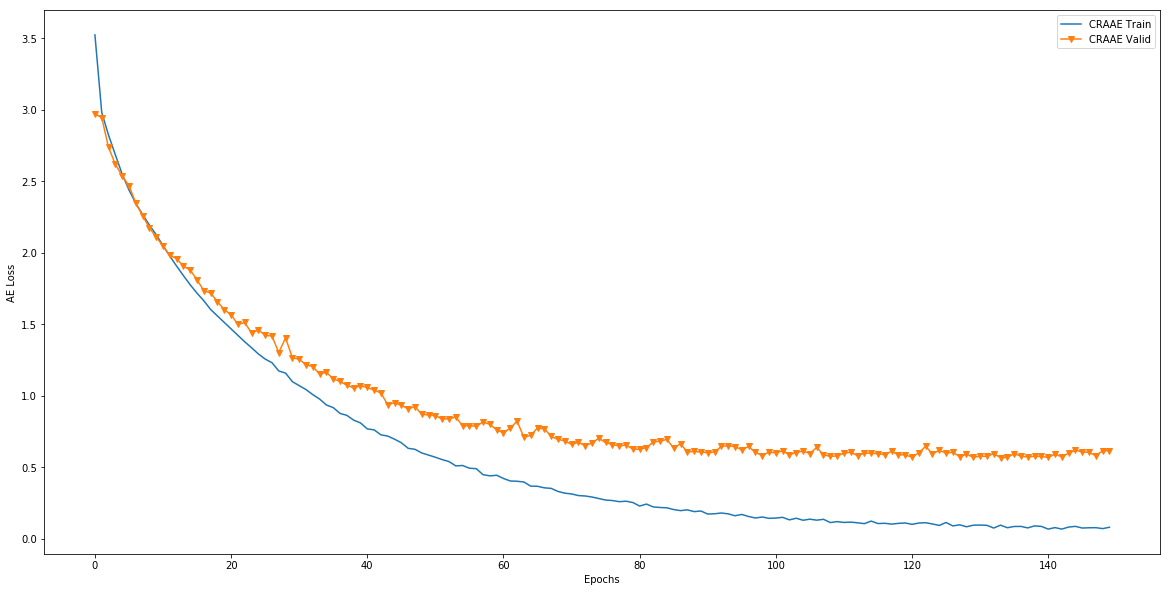

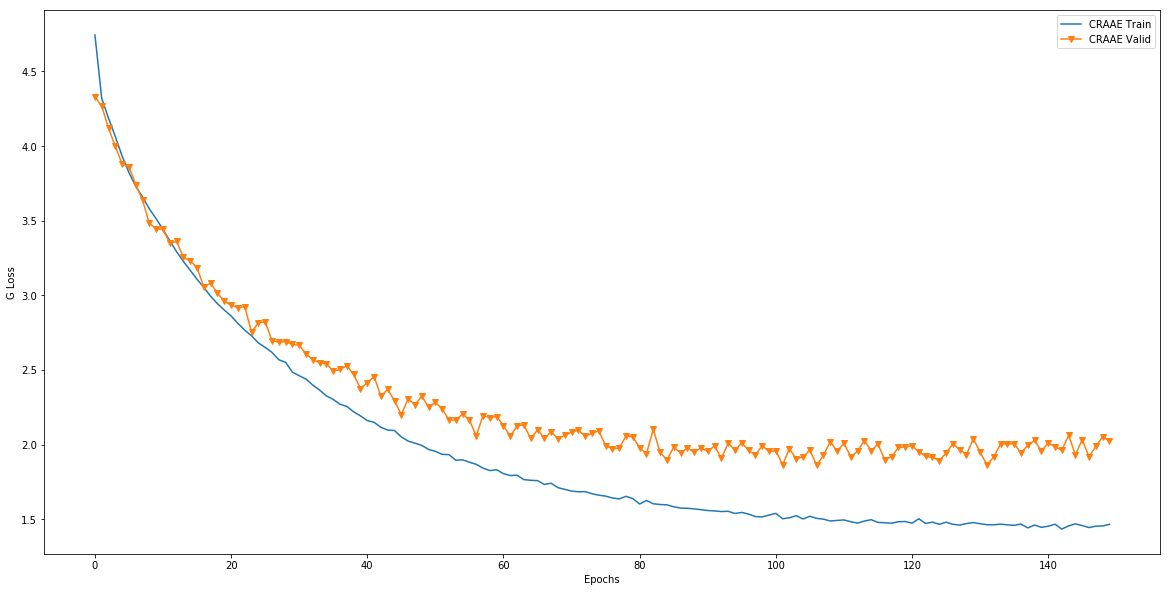

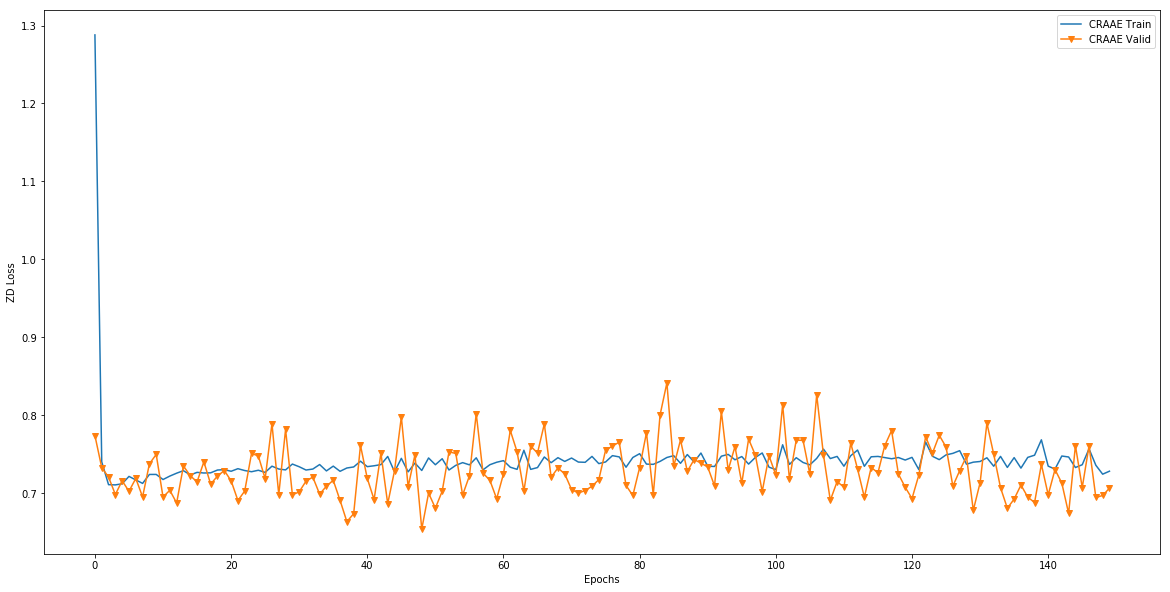

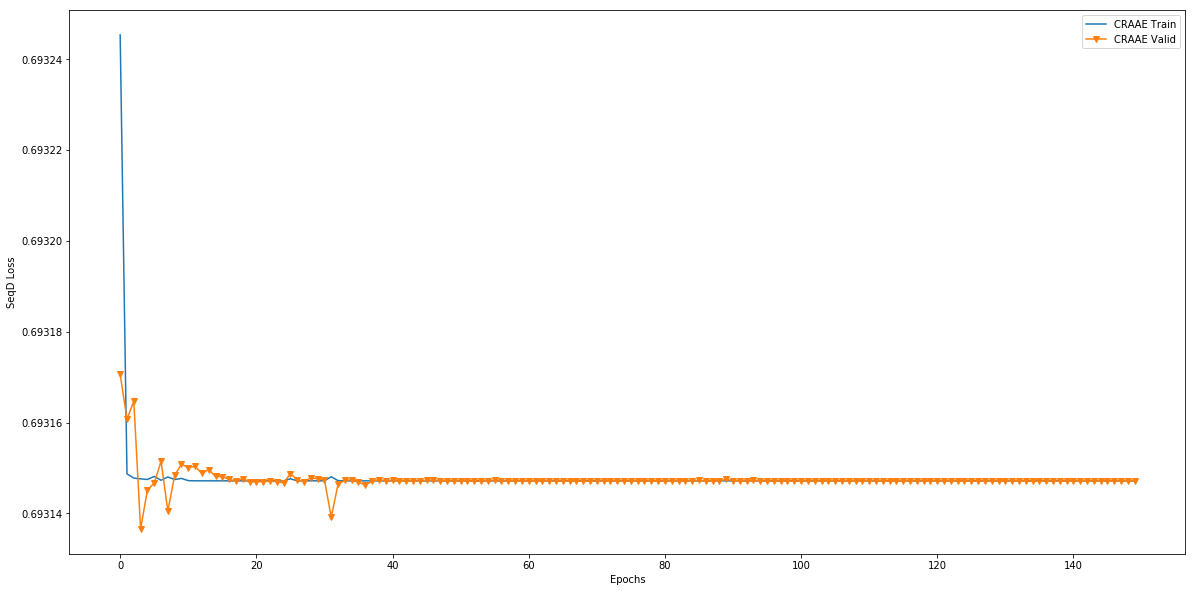

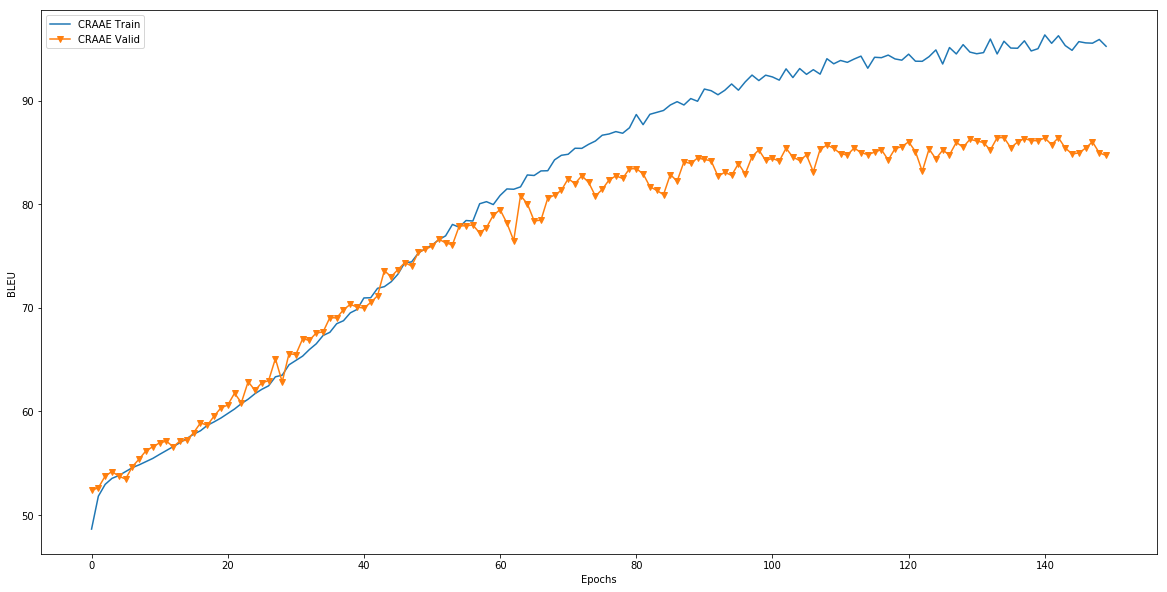

CPU times: user 12h 24min 43s, sys: 1h 31min 56s, total: 13h 56min 40s
Wall time: 14h 28min 32s


In [34]:
%%time

for epoch in range(1, 151):
    print("========== Start epoch {} at {} ==========".format(epoch, datetime.now().strftime("%H:%M:%S")))
    trn, val, _ = metrics['CRAAE']
    trn.append(train_raae(epoch, Enc, Dec, ZDisc, SeqDisc, prior_size, train_dl))
    val.append(validate_raae(epoch, Enc, Dec, ZDisc, SeqDisc, prior_size, valid_dl, 'Valid'))
    print_decoded(Enc, Dec, gen_dl)
    print_sample(Dec, sample_size=prior_size, max_seq_len=30)
            
    if epoch % 10 == 0: 
        torch.save(Enc.state_dict(), f'2Disc-{hidden_size}H-3L.enc.e{epoch}.pt')
        torch.save(Dec.state_dict(), f'2Disc-{hidden_size}H-3L.dec.e{epoch}.pt')
        torch.save(ZDisc.state_dict(), f'2Disc-{hidden_size}H-3L.zdisc.e{epoch}.pt')
        torch.save(SeqDisc.state_dict(), f'2Disc-{hidden_size}H-3L.seqdisc.e{epoch}.pt')
        plot_metrics(metrics, 0, 'AE Loss')
        plot_metrics(metrics, 1, 'G Loss')
        plot_metrics(metrics, 2, 'ZD Loss')
        plot_metrics(metrics, 3, 'SeqD Loss')
        plot_metrics(metrics, 4, 'BLEU')
        